# Activation Maximization (AM)

Activation maximization is an explainability technique that generates synthetic input samples to maximize (or minimize) the output of a neural network model. By optimizing the input to strongly activate a particular neuron or output, we can gain insights into what patterns or features the model has learned to associate with high or low predictions.

Here we examine how the by-cell-lines activization maximizations differ from each other and the genral "prototypical AM output"
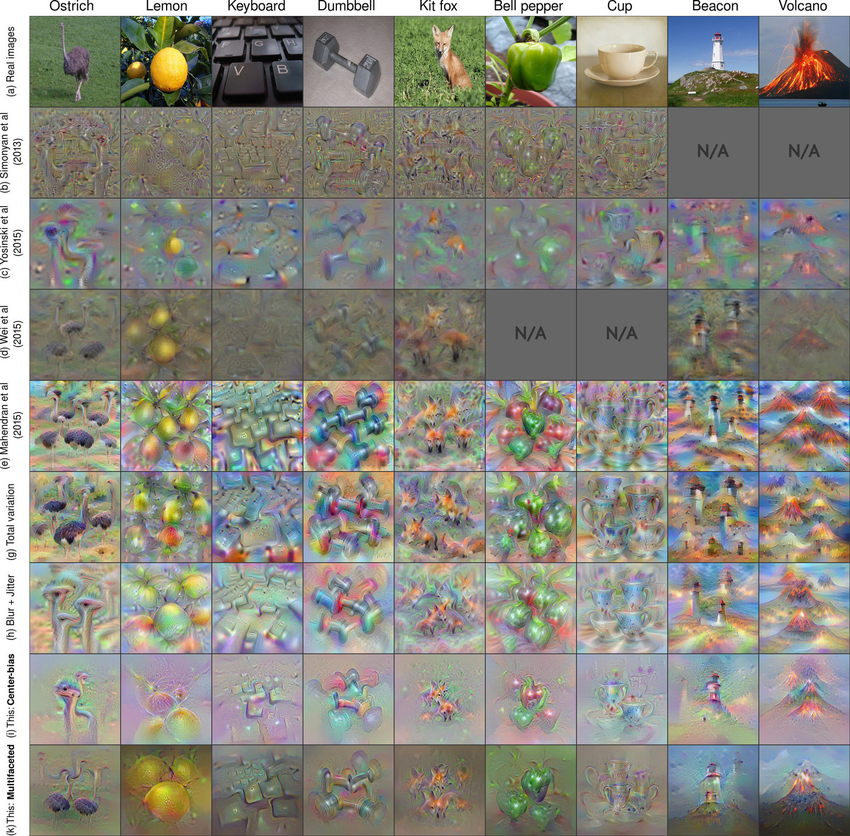

Since it is very important to NOT have the input (which is the output) of AM be on an edge of a manifold - we do regularize one variant (with L2) to the input distribution by using the mean of the distribution and penalising staying to far away from the z-score space of the input data (X).

In [2]:
import sys
from pathlib import Path
import os 

# Assuming this notebook is in: explainability/notebooks/
# So we go two levels up to reach the root where 'explainability/' lives
project_root = Path.cwd().parents[1]  # cwd = explainability/notebooks/
# join paths -> project root /explainability
explainability_path = project_root / "explainability"


sys.path.append(str(explainability_path))
os.chdir(project_root)

In [1]:
import os
os.getcwd()

'c:\\Users\\ismyn\\UNI\\FU Berlin\\SWP_Cancer\\Drug-Inhibitor-Cancer-Treatment\\explainability\\notebooks'

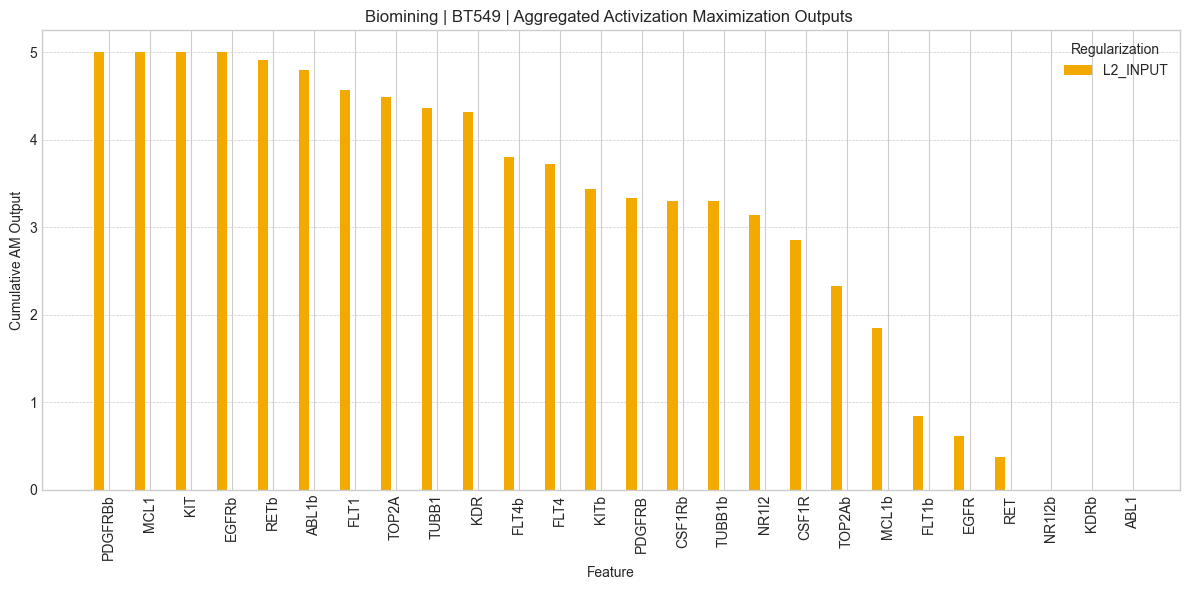

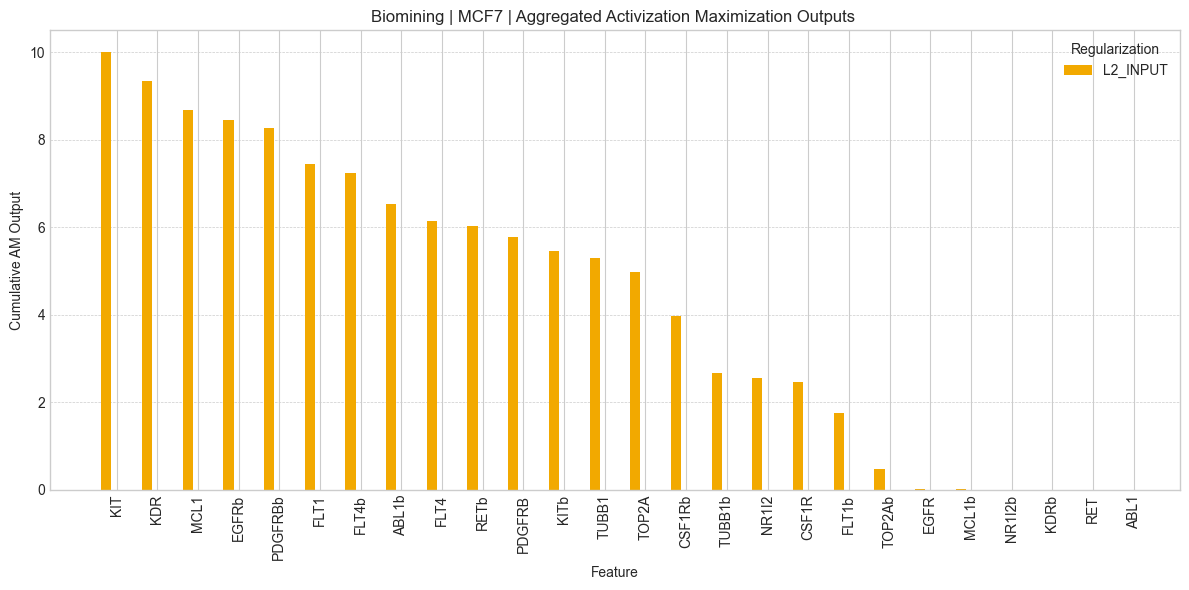

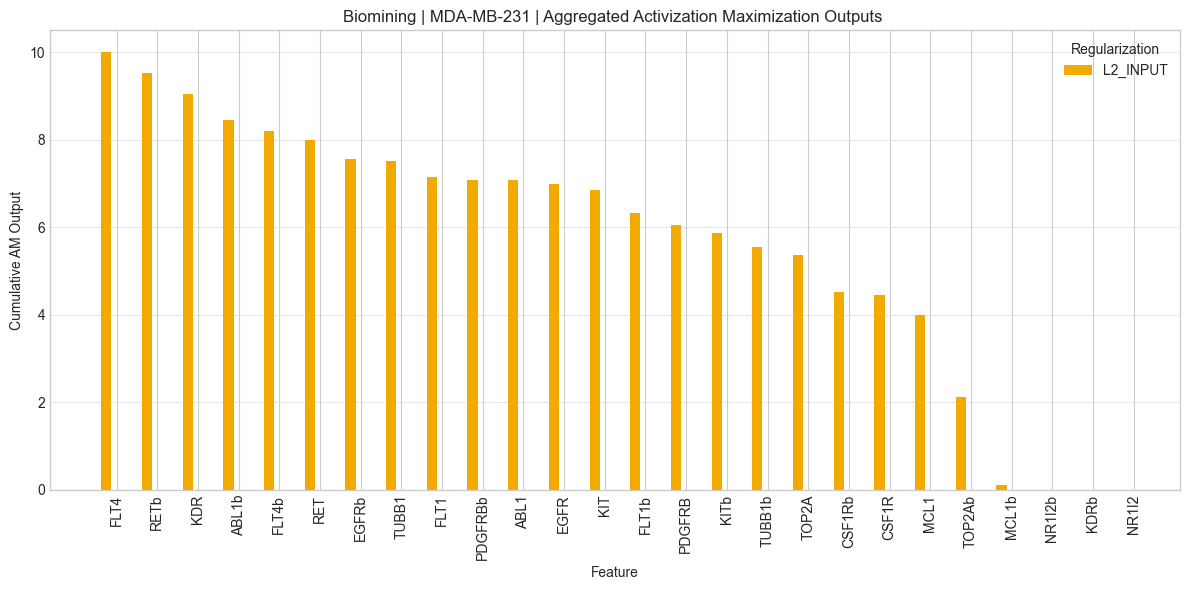

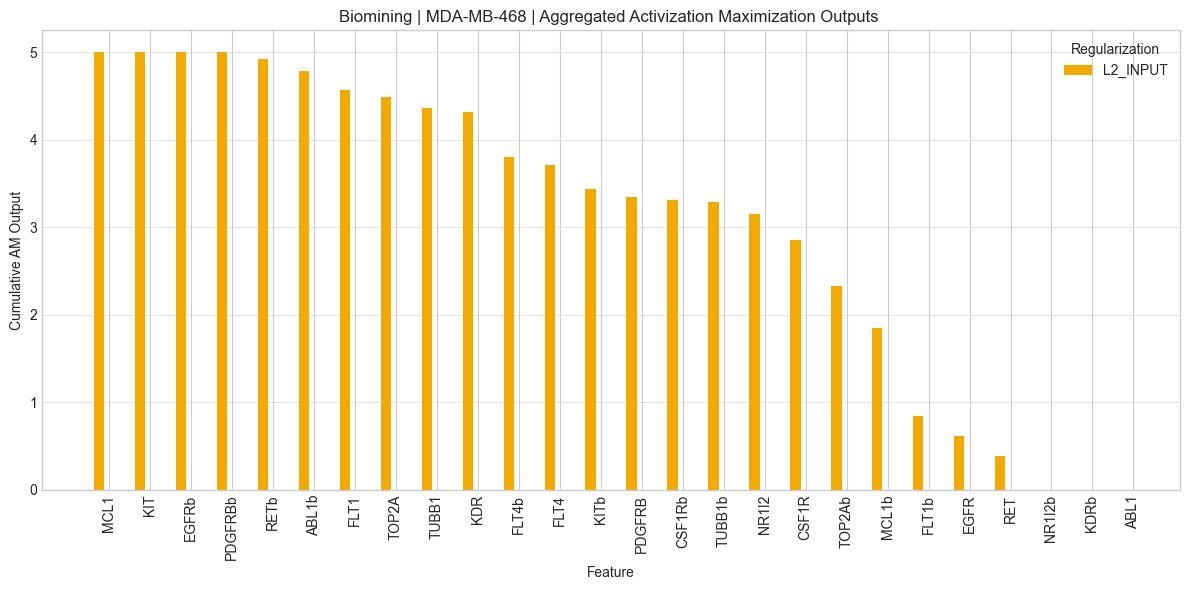

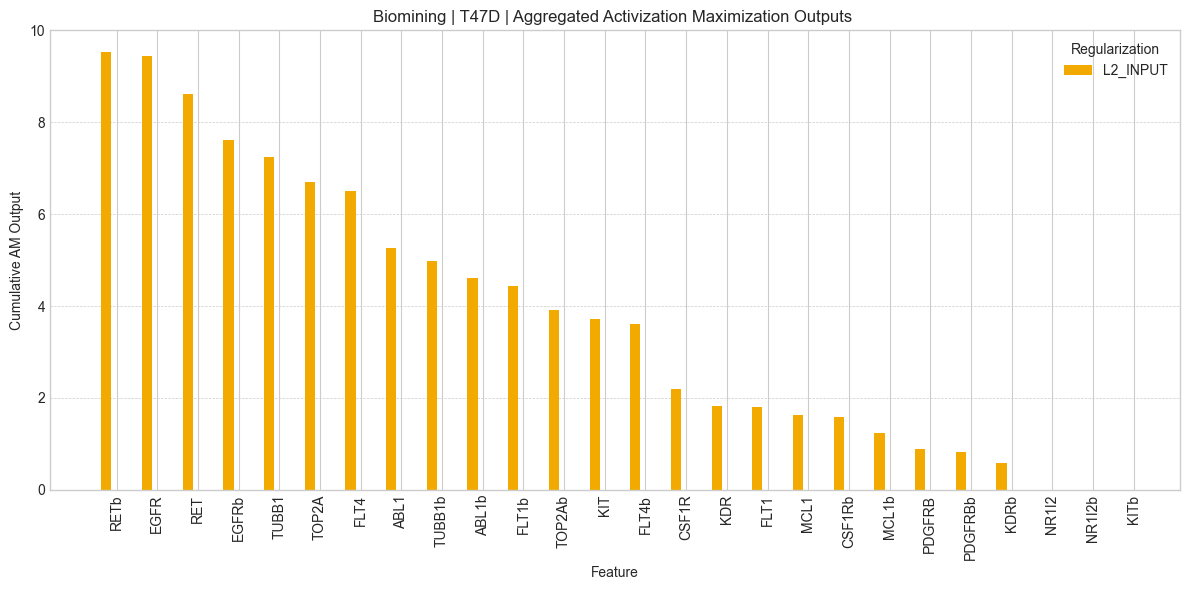

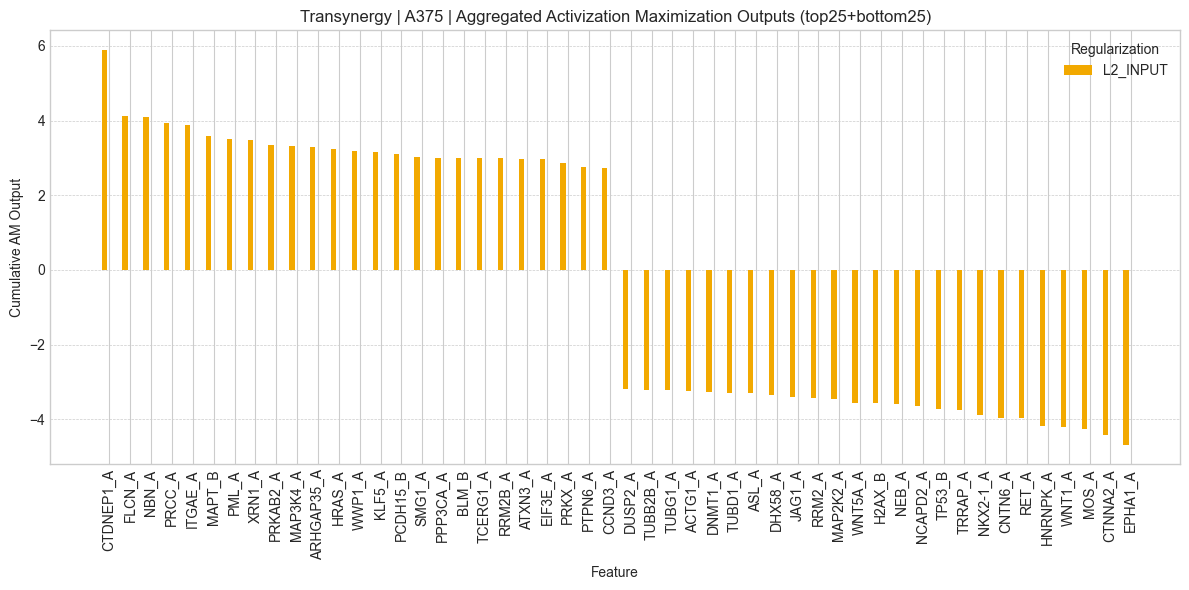

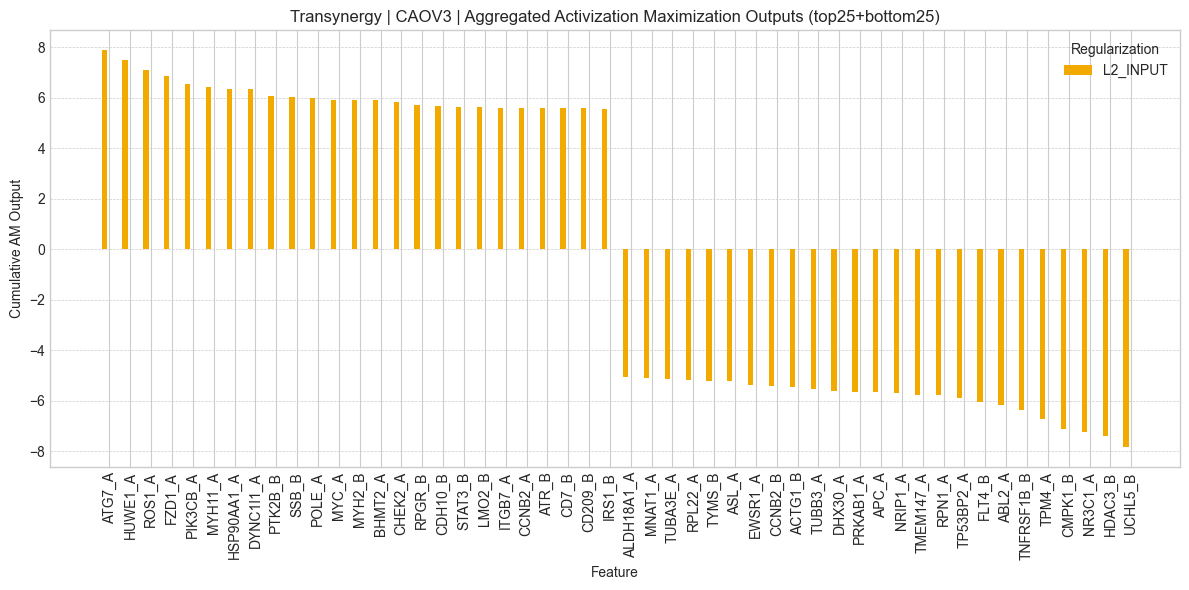

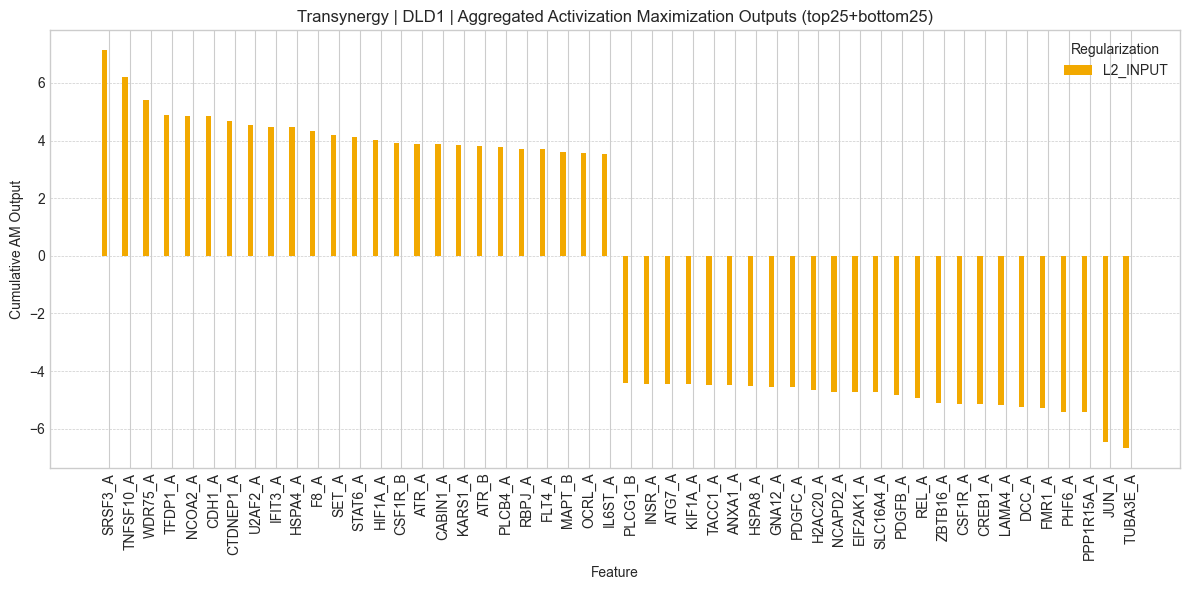

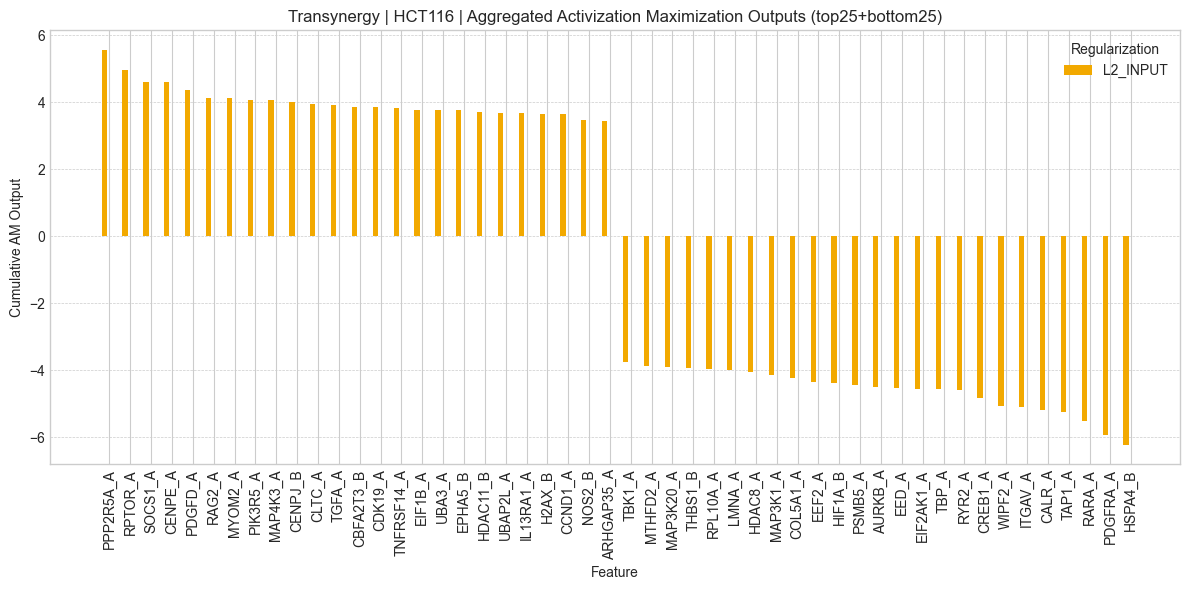

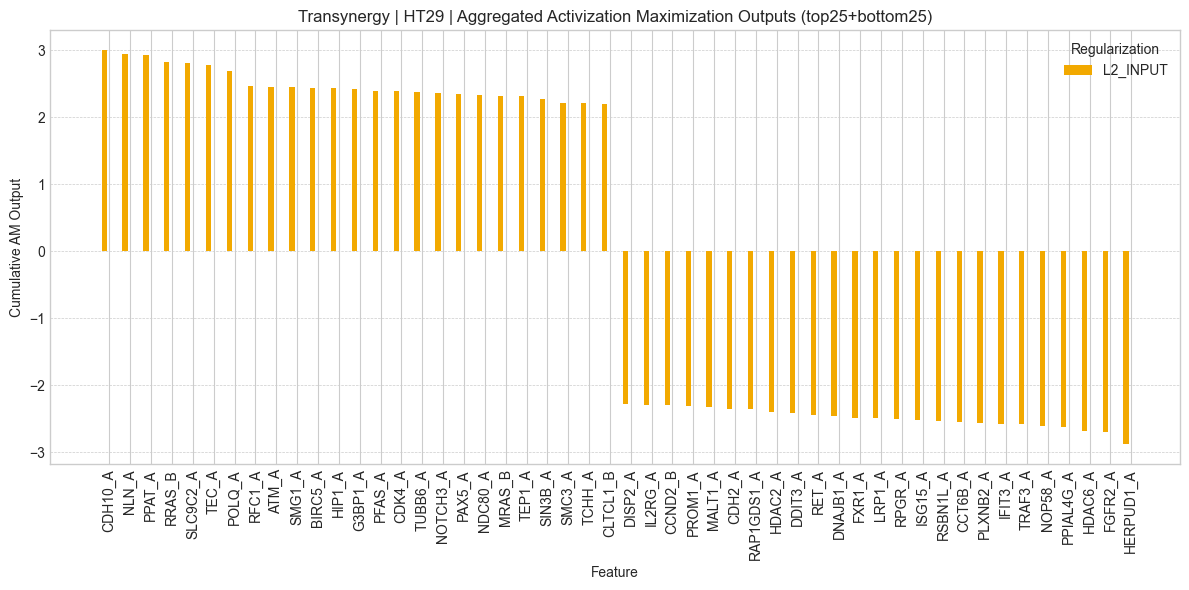

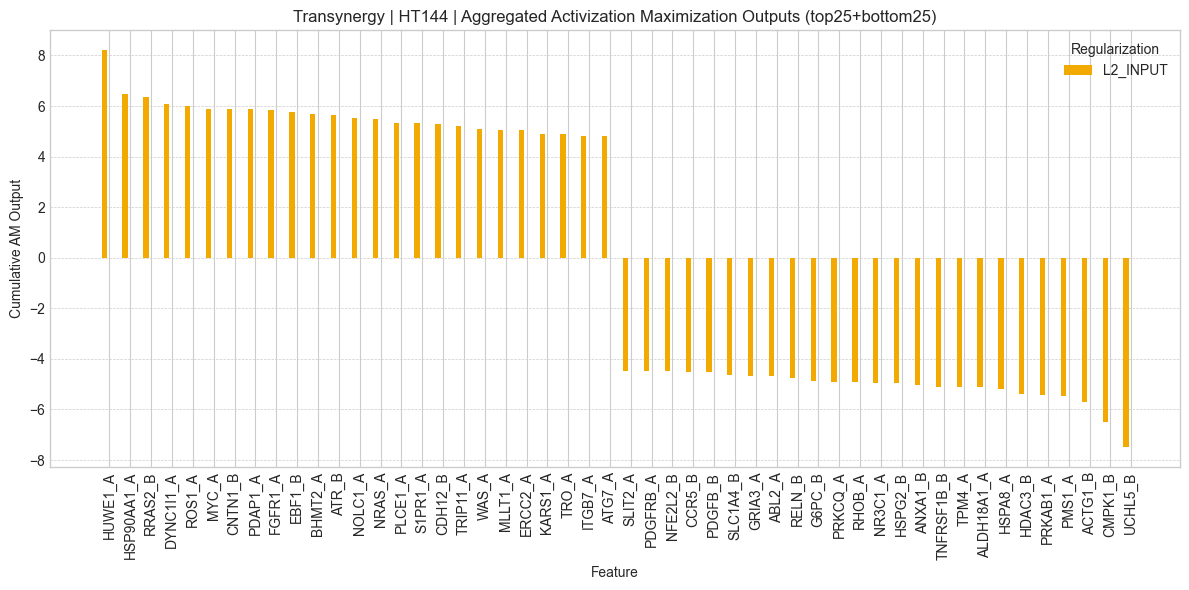

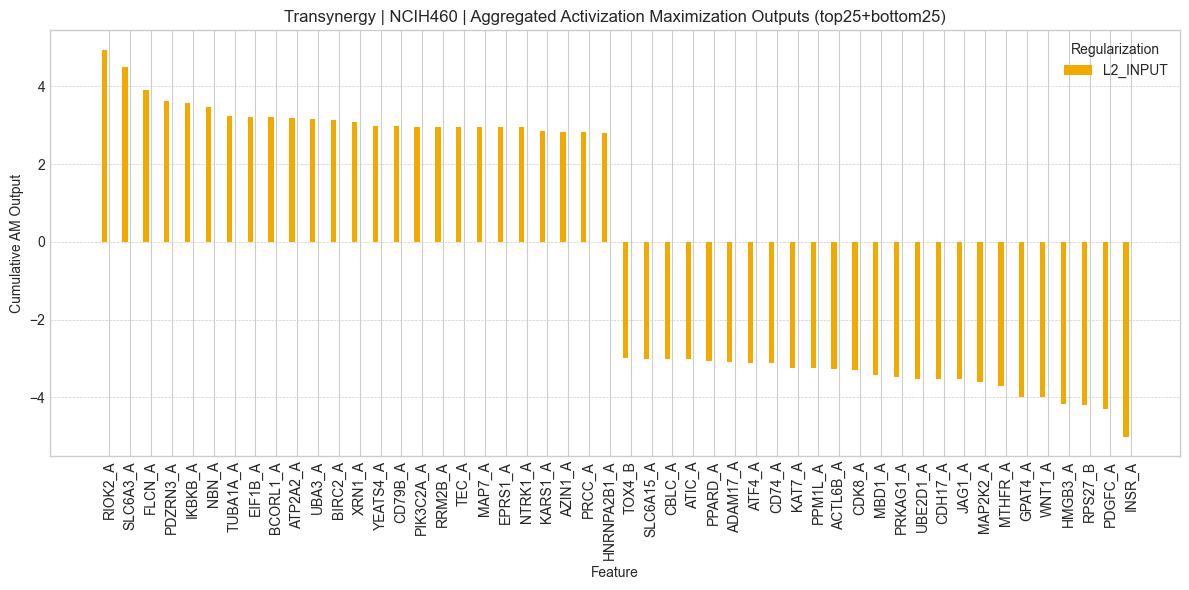

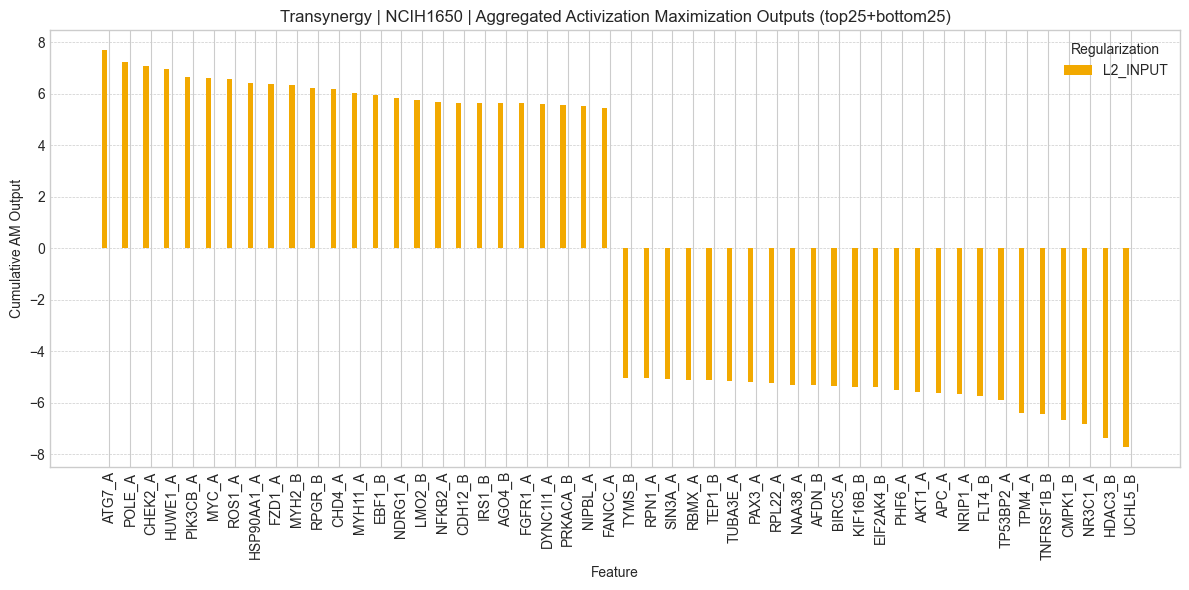

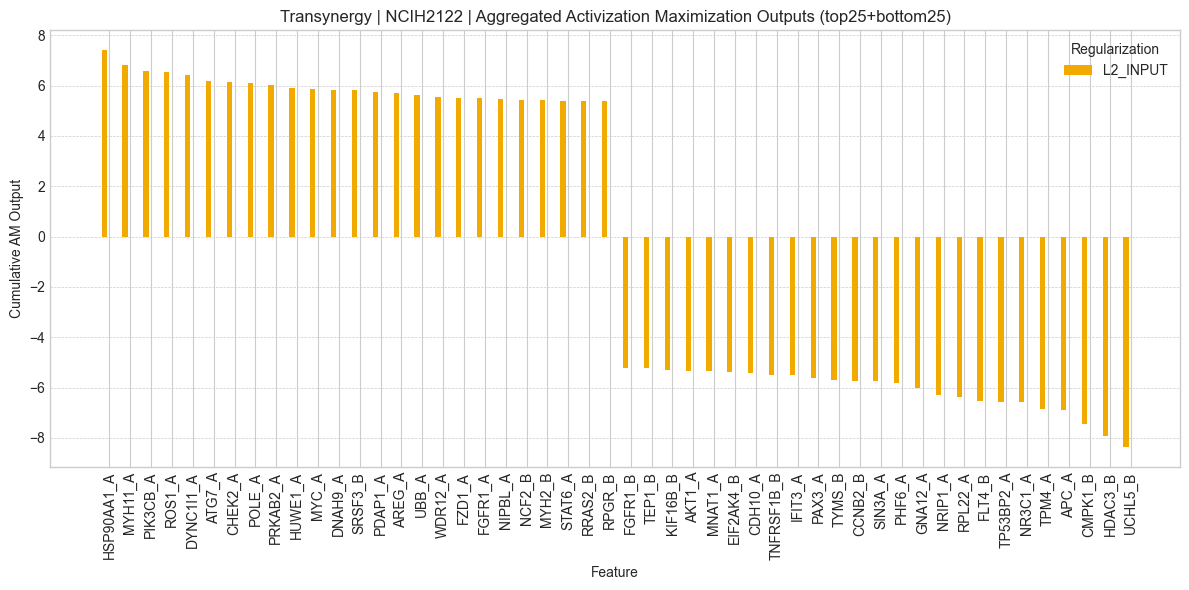

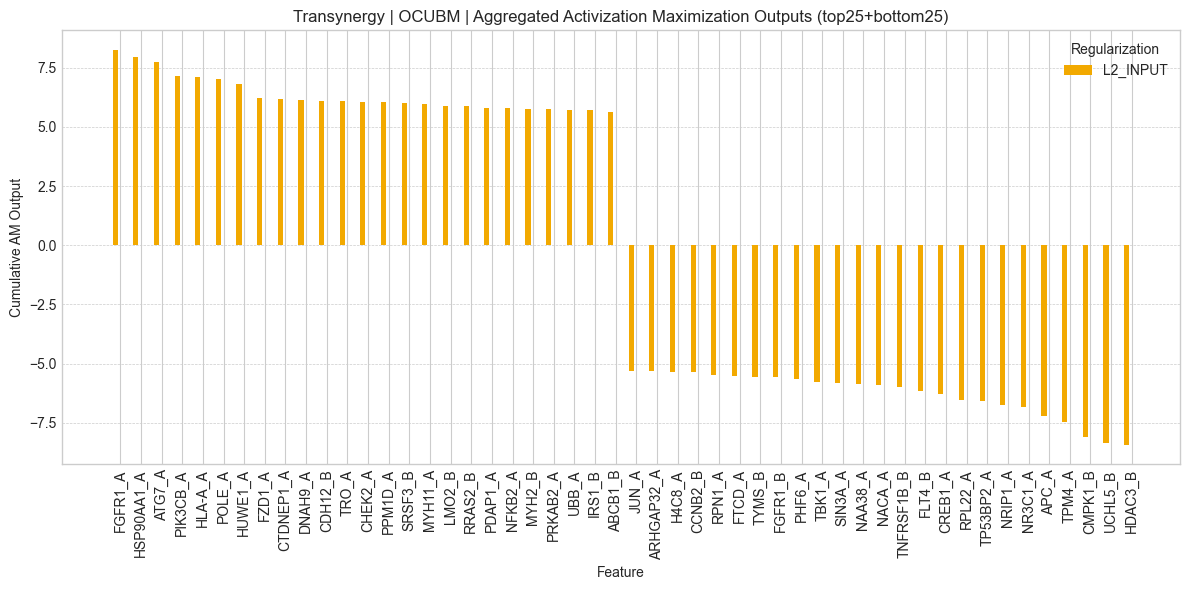

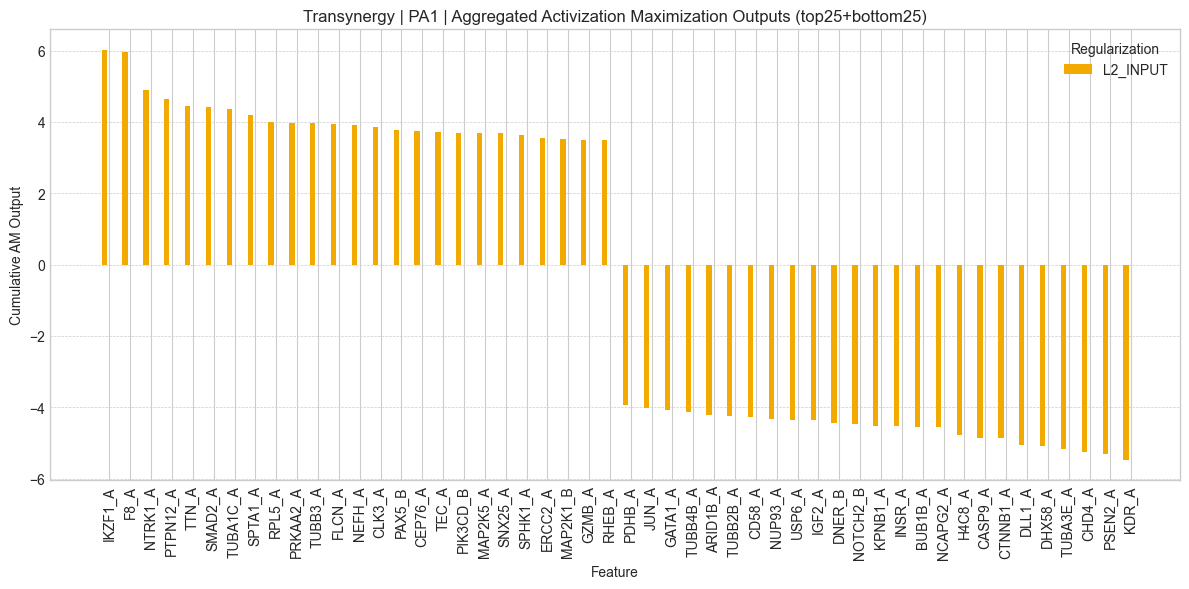

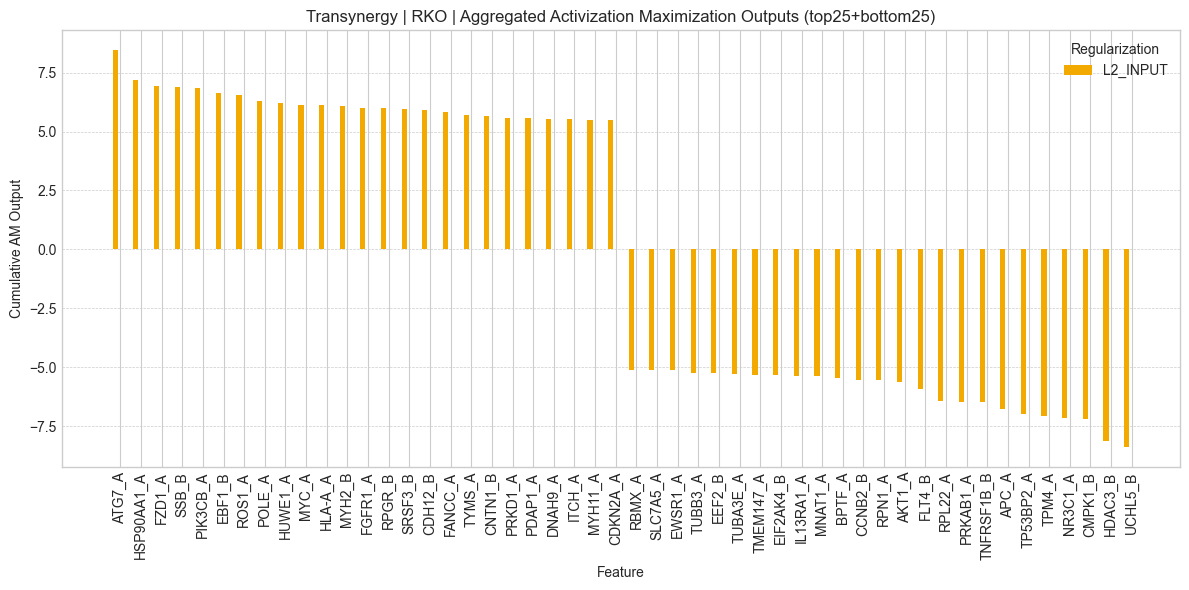

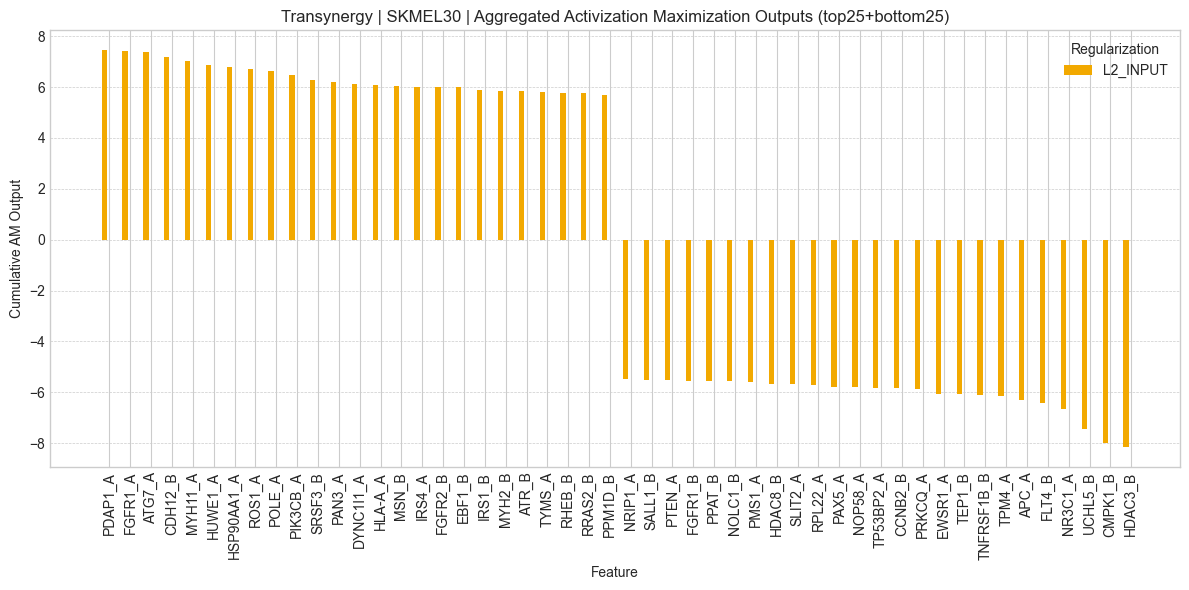

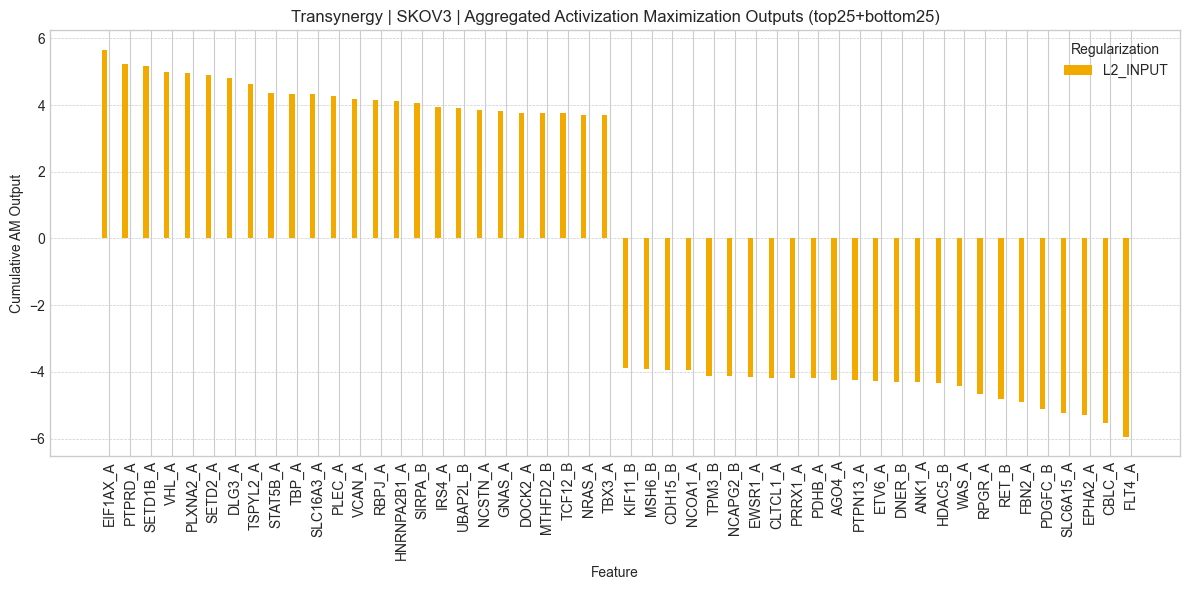

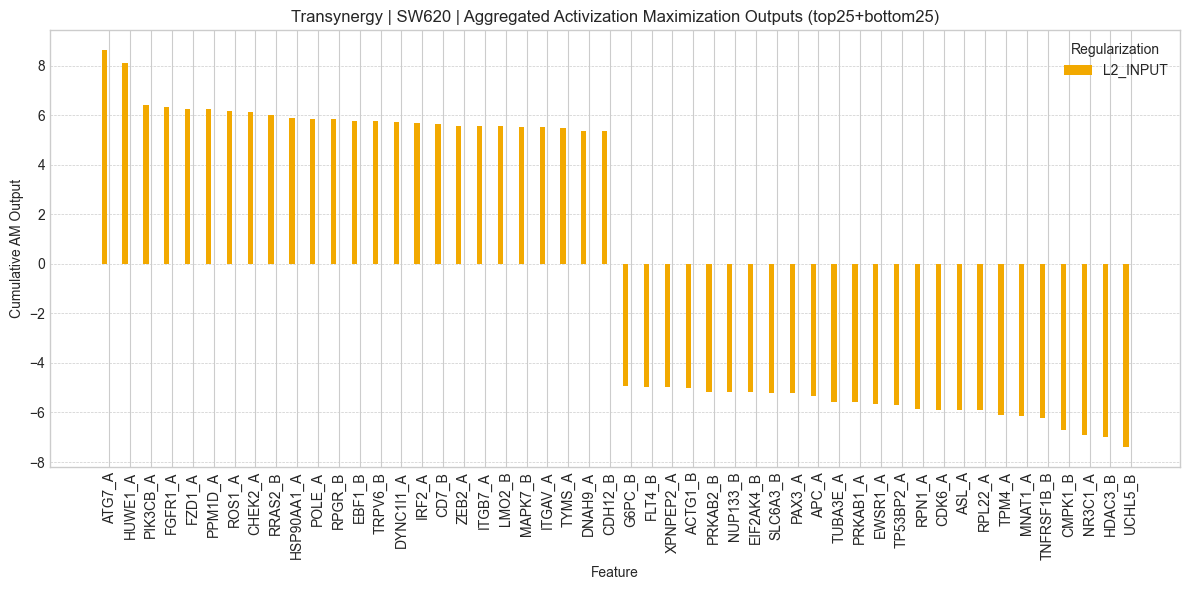

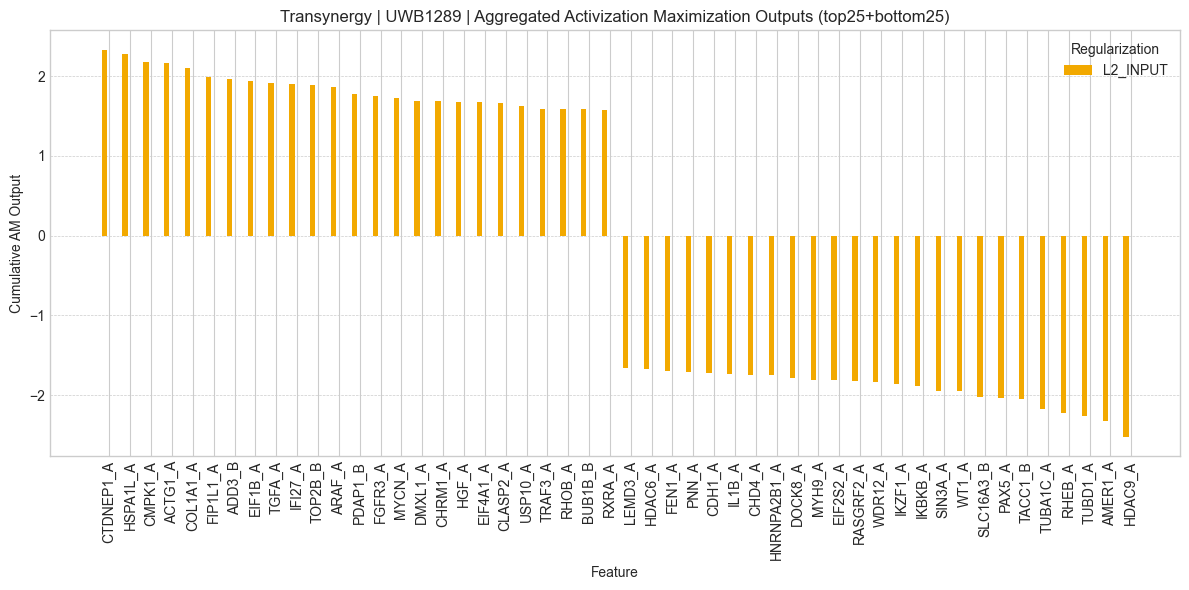

In [12]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from explaination_config import ExplainationConfig

plt.style.use("seaborn-v0_8-whitegrid")

regularizations = ["l2_input"]
colors = {
    "l2_input": "#F2A900"  # orange
}
minimaxis = ["max", "min"]
papers = ["biomining", "transynergy"]
cell_line_names = {
    'biomining': ["BT549", "MCF7", "MDA-MB-231", "MDA-MB-468", "T47D"],
    'transynergy': ["A375",
                    "CAOV3",
                    "DLD1",
                    "HCT116",
                    "HT29",
                    "HT144",
                    "NCIH460",
                    "NCIH1650",
                    "NCIH2122",
                    "OCUBM",
                    "PA1",
                    "RKO",
                    "SKMEL30",
                    "SKOV3",
                    "SW620",
                    "UWB1289"]
}
dict_papers_indices_l2 = {}
for paper in papers:
    feature_names = ExplainationConfig(paper=paper).feature_names
    cell_lines = cell_line_names[paper]
    for cell_line in cell_lines:
        SORTED_ORDER_INDICES = None
        feature_importance_all_regs = {}
        

        for reg in regularizations:
            path_to_experiment = os.path.join(os.getcwd(), f"explainability/am/results/by_cell_line/{paper}_{cell_line}_max_reg_{reg}")
            feature_importance = torch.zeros(len(feature_names))
            for file in os.listdir(path_to_experiment):
                if file.endswith(".pt"):
                    tensor = torch.load(os.path.join(path_to_experiment, file))
                    feature_importance += tensor
                    
            importance_array = feature_importance.numpy()
            feature_importance_all_regs[reg] = importance_array.tolist()
            if paper == 'transynergy':
                index_max =  4804
            elif paper == 'biomining':
                index_max =  26
            if SORTED_ORDER_INDICES is None:
                # Sort based on this reg (first one in loop)
                full_sorted_indices = np.argsort(-importance_array)  # descending
                full_sorted_indices = full_sorted_indices.tolist()
                full_sorted_indices = [i for i in full_sorted_indices if i < index_max]  # Filter indices
                dict_papers_indices_l2[(paper, cell_line)] = full_sorted_indices
                if len(feature_names) > 50:
                    # Take top 25 and bottom 25
                    top_25 = full_sorted_indices[:25]
                    bottom_25 = full_sorted_indices[-25:]
                    SORTED_ORDER_INDICES = top_25 + bottom_25
                else:
                    SORTED_ORDER_INDICES = full_sorted_indices

        sorted_feature_names = [feature_names[i] for i in SORTED_ORDER_INDICES]
        # Aggregate feature importance across regularizations
        # Plot aggregated bar chart
        plt.figure(figsize=(12, 6))
        bar_width = 0.25
        x = range(len(SORTED_ORDER_INDICES))

        for idx, reg in enumerate(regularizations):
            sorted_values = [feature_importance_all_regs[reg][i] for i in SORTED_ORDER_INDICES]
            offset = [xi + (idx - 1) * bar_width for xi in x]  # shift bars
            plt.bar(offset, sorted_values, width=bar_width, label=reg.upper(), color=colors[reg])

        if len(feature_names) > 50:
            suffix = "(top25+bottom25)"
        else:
            suffix = ""
        plt.xticks(x, sorted_feature_names, rotation=90)
        plt.title(f"{paper.capitalize()} | {cell_line.upper()} | Aggregated Activization Maximization Outputs {suffix}")
        plt.xlabel("Feature")
        plt.ylabel("Cumulative AM Output")
        plt.legend(title="Regularization")
        plt.tight_layout()
        plt.grid(axis='y', linestyle='--', linewidth=0.5)
        plt.show()


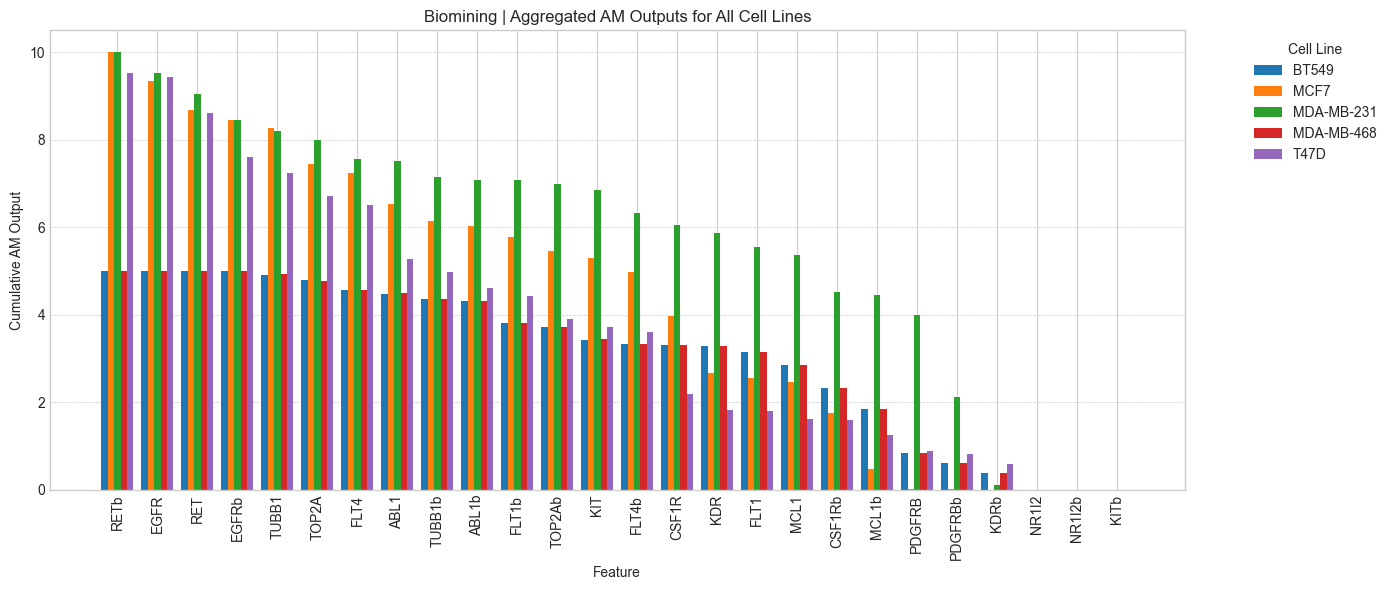

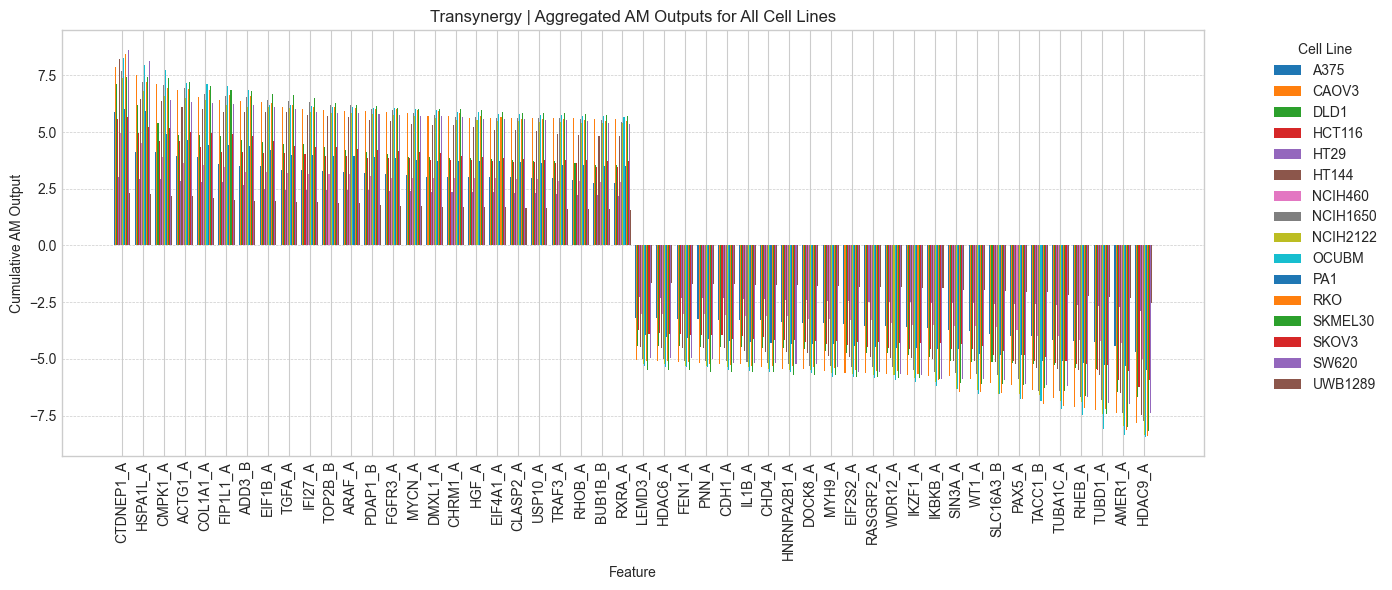

In [ ]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from explaination_config import ExplainationConfig

plt.style.use("seaborn-v0_8-whitegrid")

regularizations = ["l2_input"]
colors = {
    "l2_input": "#F2A900"  # orange
}
papers = ["biomining", "transynergy"]
cell_line_names = {
    'biomining': ["BT549", "MCF7", "MDA-MB-231", "MDA-MB-468", "T47D", "prototypeAM"],
    'transynergy': ["A375", "CAOV3", "DLD1", "HCT116", "HT29", "HT144",
                    "NCIH460", "NCIH1650", "NCIH2122", "OCUBM", "PA1", "RKO",
                    "SKMEL30", "SKOV3", "SW620", "UWB1289", "prototypeAM"]
}
index_max_by_paper = {'biomining': 26, 'transynergy': 4804}

for paper in papers:
    feature_names = ExplainationConfig(paper=paper).feature_names
    cell_lines = cell_line_names[paper]
    index_max = index_max_by_paper[paper]
    feature_importance_per_cell_line = {}

    # Collect importance per cell line
    for cell_line in cell_lines:
        if cell_line == 'prototypeAM':
            path_to_experiment = os.path.join(
            os.getcwd(), f"explainability/am/results/by_cell_line/{paper}__max_reg_l2_input"
        )
        else:
            path_to_experiment = os.path.join(
            os.getcwd(), f"explainability/am/results/by_cell_line/{paper}_{cell_line}_max_reg_l2_input"
        )
        feature_importance = torch.zeros(len(feature_names))
        for file in os.listdir(path_to_experiment):
            if file.endswith(".pt"):
                tensor = torch.load(os.path.join(path_to_experiment, file))
                feature_importance += tensor

        importance_array = feature_importance.numpy()
        sorted_indices = np.argsort(-importance_array)
        sorted_indices = [i for i in sorted_indices if i < index_max]

        if len(feature_names) > 50:
            top_25 = sorted_indices[:25]
            bottom_25 = sorted_indices[-25:]
            final_indices = top_25 + bottom_25
        else:
            final_indices = sorted_indices

        feature_importance_per_cell_line[cell_line] = [importance_array[i] for i in final_indices]

    # Plot for one paper (all cell lines)
    plt.figure(figsize=(14, 6))
    x = np.arange(len(final_indices))
    bar_width = 0.8 / len(cell_lines)

    for idx, cell_line in enumerate(cell_lines):
        offset = x + (idx - len(cell_lines) / 2) * bar_width + bar_width / 2
        plt.bar(offset,
                feature_importance_per_cell_line[cell_line],
                width=bar_width,
                label=cell_line)

    sorted_feature_names = [feature_names[i] for i in final_indices]
    plt.xticks(x, sorted_feature_names, rotation=90)
    plt.title(f"{paper.capitalize()} | Aggregated AM Outputs for All Cell Lines")
    plt.xlabel("Feature")
    plt.ylabel("Cumulative AM Output")
    plt.legend(title="Cell Line", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', linewidth=0.5)
    plt.show()


In [ ]:
import os
import torch
import matplotlib.pyplot as plt
from explaination_config import ExplainationConfig

plt.style.use("seaborn-v0_8-whitegrid")

regularizations = ["l2_input"]
colors = {
    "l2_input": "#F2A900"  # orange
}
papers = ["biomining", "transynergy"]
cell_line_names = {
    'biomining': ["BT549", "MCF7", "MDA-MB-231", "MDA-MB-468", "T47D"],
    'transynergy': ["A375", "CAOV3", "DLD1", "HCT116", "HT29", "HT144", "NCIH460",
                    "NCIH1650", "NCIH2122", "OCUBM", "PA1", "RKO", "SKMEL30", "SKOV3",
                    "SW620", "UWB1289"]
}

for paper in papers:
    feature_names = ExplainationConfig(paper=paper).feature_names
    n_features = len(feature_names)
    cell_lines = cell_line_names[paper]

    # Aggregate feature importance over all cell lines
    feature_importance_all_regs = {reg: torch.zeros(n_features) for reg in regularizations}

    for cell_line in cell_lines:
        for reg in regularizations:
            path_to_experiment = os.path.join(
                os.getcwd(), f"explainability/am/results/by_cell_line/{paper}_{cell_line}_max_reg_{reg}"
            )
            for file in os.listdir(path_to_experiment):
                if file.endswith(".pt"):
                    tensor = torch.load(os.path.join(path_to_experiment, file))
                    feature_importance_all_regs[reg] += tensor

    # Sort features by importance using first reg
    reg0 = regularizations[0]
    importance_values = feature_importance_all_regs[reg0].tolist()
    full_sorted_indices = sorted(range(n_features), key=lambda i: importance_values[i], reverse=True)

    if n_features > 50:
        top_25 = full_sorted_indices[:25]
        bottom_25 = full_sorted_indices[-25:]
        sorted_indices = top_25 + bottom_25
        suffix = "(top25+bottom25)"
    else:
        sorted_indices = full_sorted_indices
        suffix = ""

    sorted_feature_names = [feature_names[i] for i in sorted_indices]

    # Plot
    plt.figure(figsize=(12, 6))
    bar_width = 0.25
    x = range(len(sorted_indices))

    for idx, reg in enumerate(regularizations):
        sorted_values = [feature_importance_all_regs[reg][i] for i in sorted_indices]
        offset = [xi + (idx - 1) * bar_width for xi in x]
        plt.bar(offset, sorted_values, width=bar_width, label=reg.upper(), color=colors[reg])

    plt.xticks(x, sorted_feature_names, rotation=90)
    plt.title(f"{paper.capitalize()} | Aggregated Across All Cell Lines {suffix}")
    plt.xlabel("Feature")
    plt.ylabel("Cumulative AM Output")
    plt.legend(title="Regularization")
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', linewidth=0.5)
    plt.show()


In [4]:
os.getcwd()

'c:\\Users\\ismyn\\UNI\\FU Berlin\\SWP_Cancer\\Drug-Inhibitor-Cancer-Treatment'

Sorting for biomining | max | l2_input
Plotting for biomining | max | 
Plotting for biomining | min | 


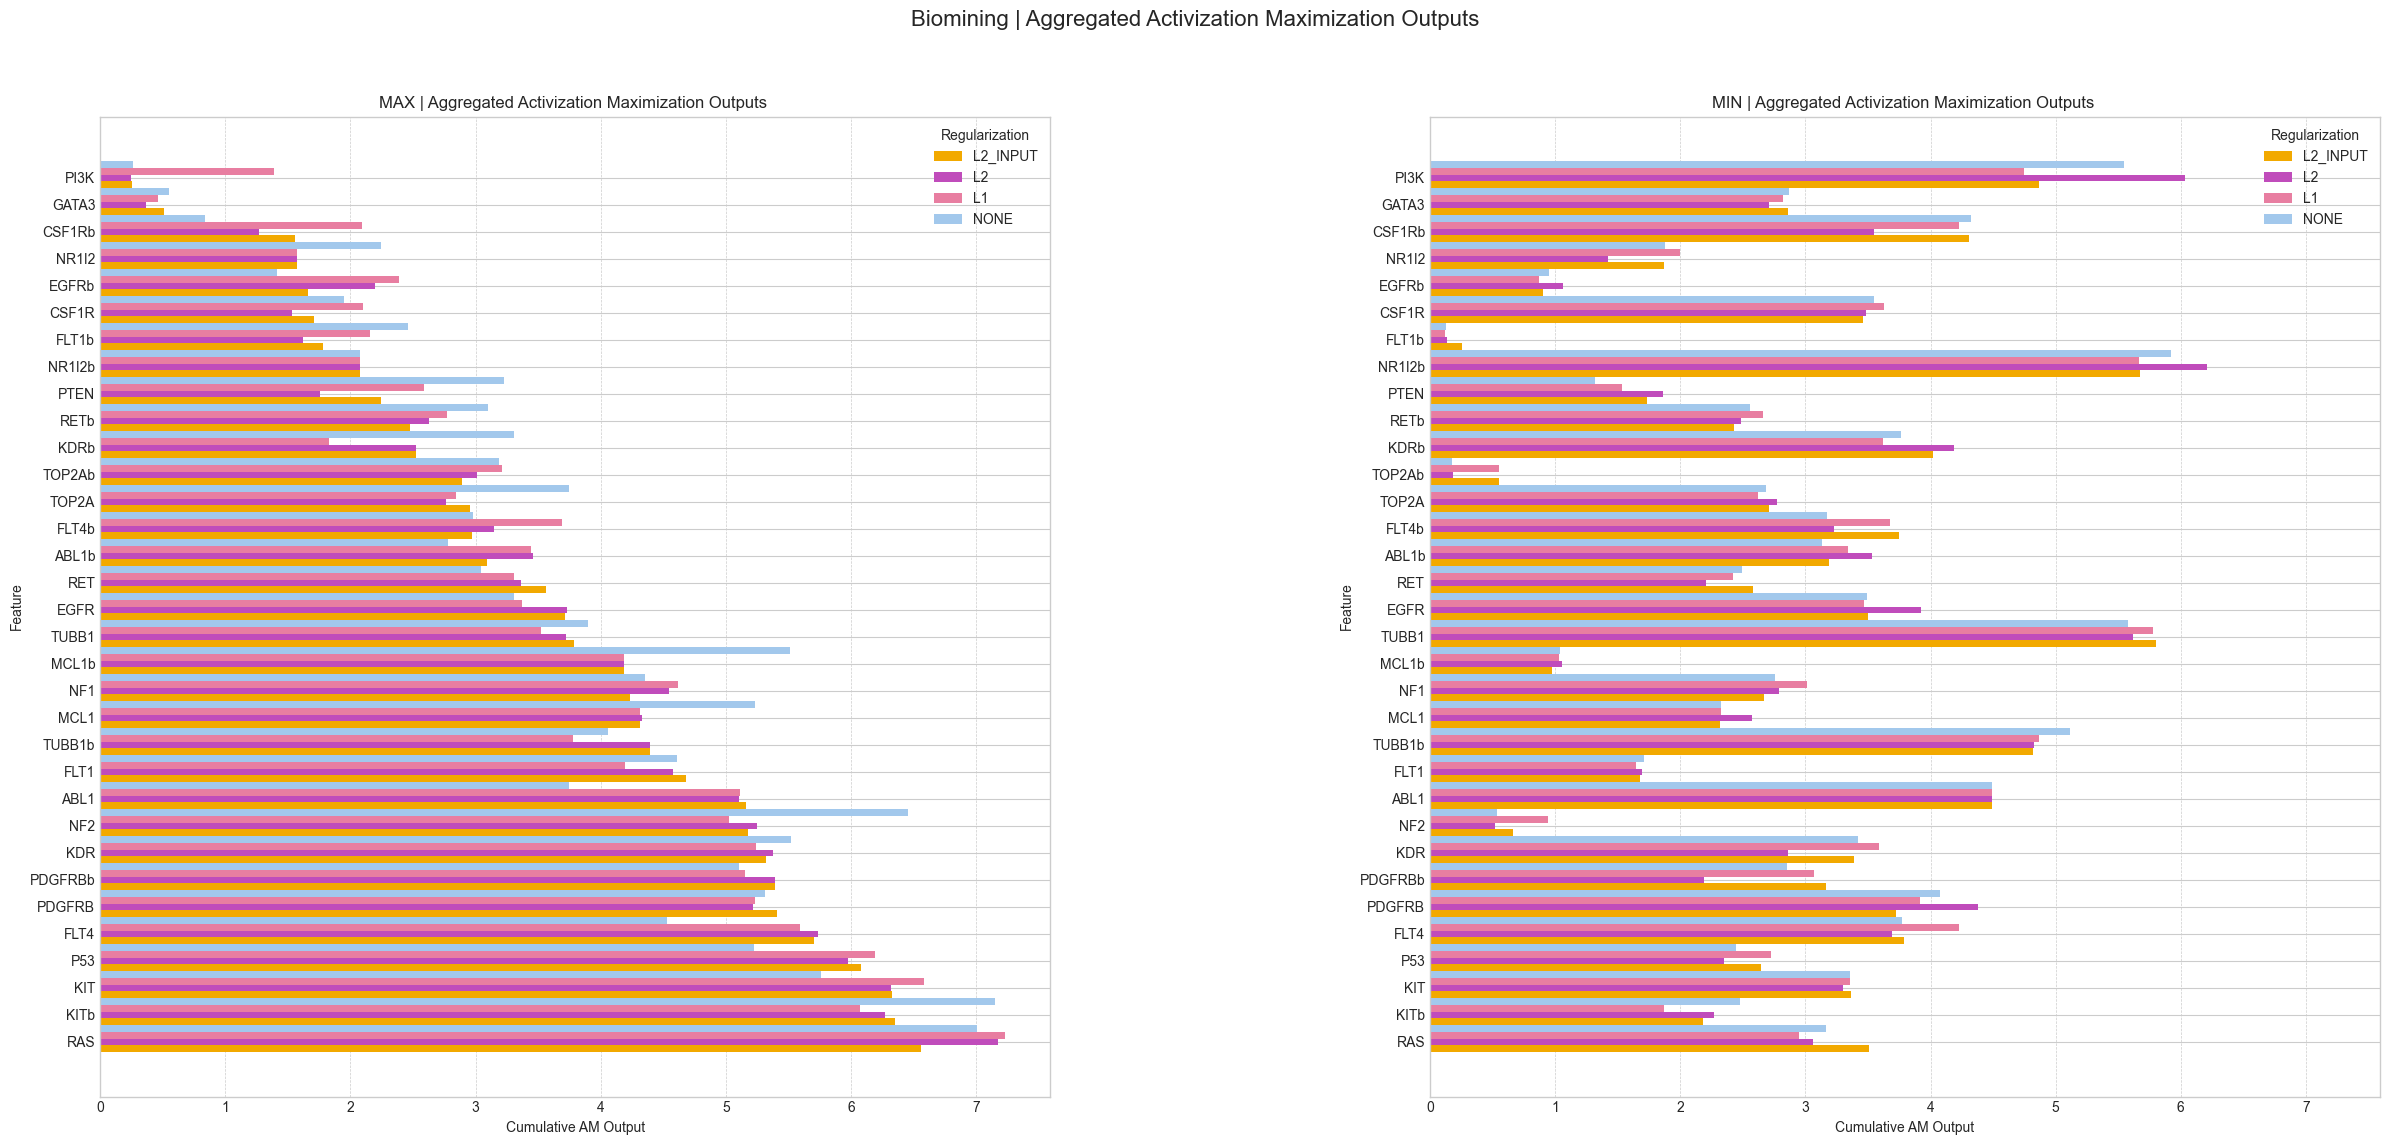

Sorting for biomining | min | l2_input
Plotting for biomining | min | 
Plotting for biomining | max | 


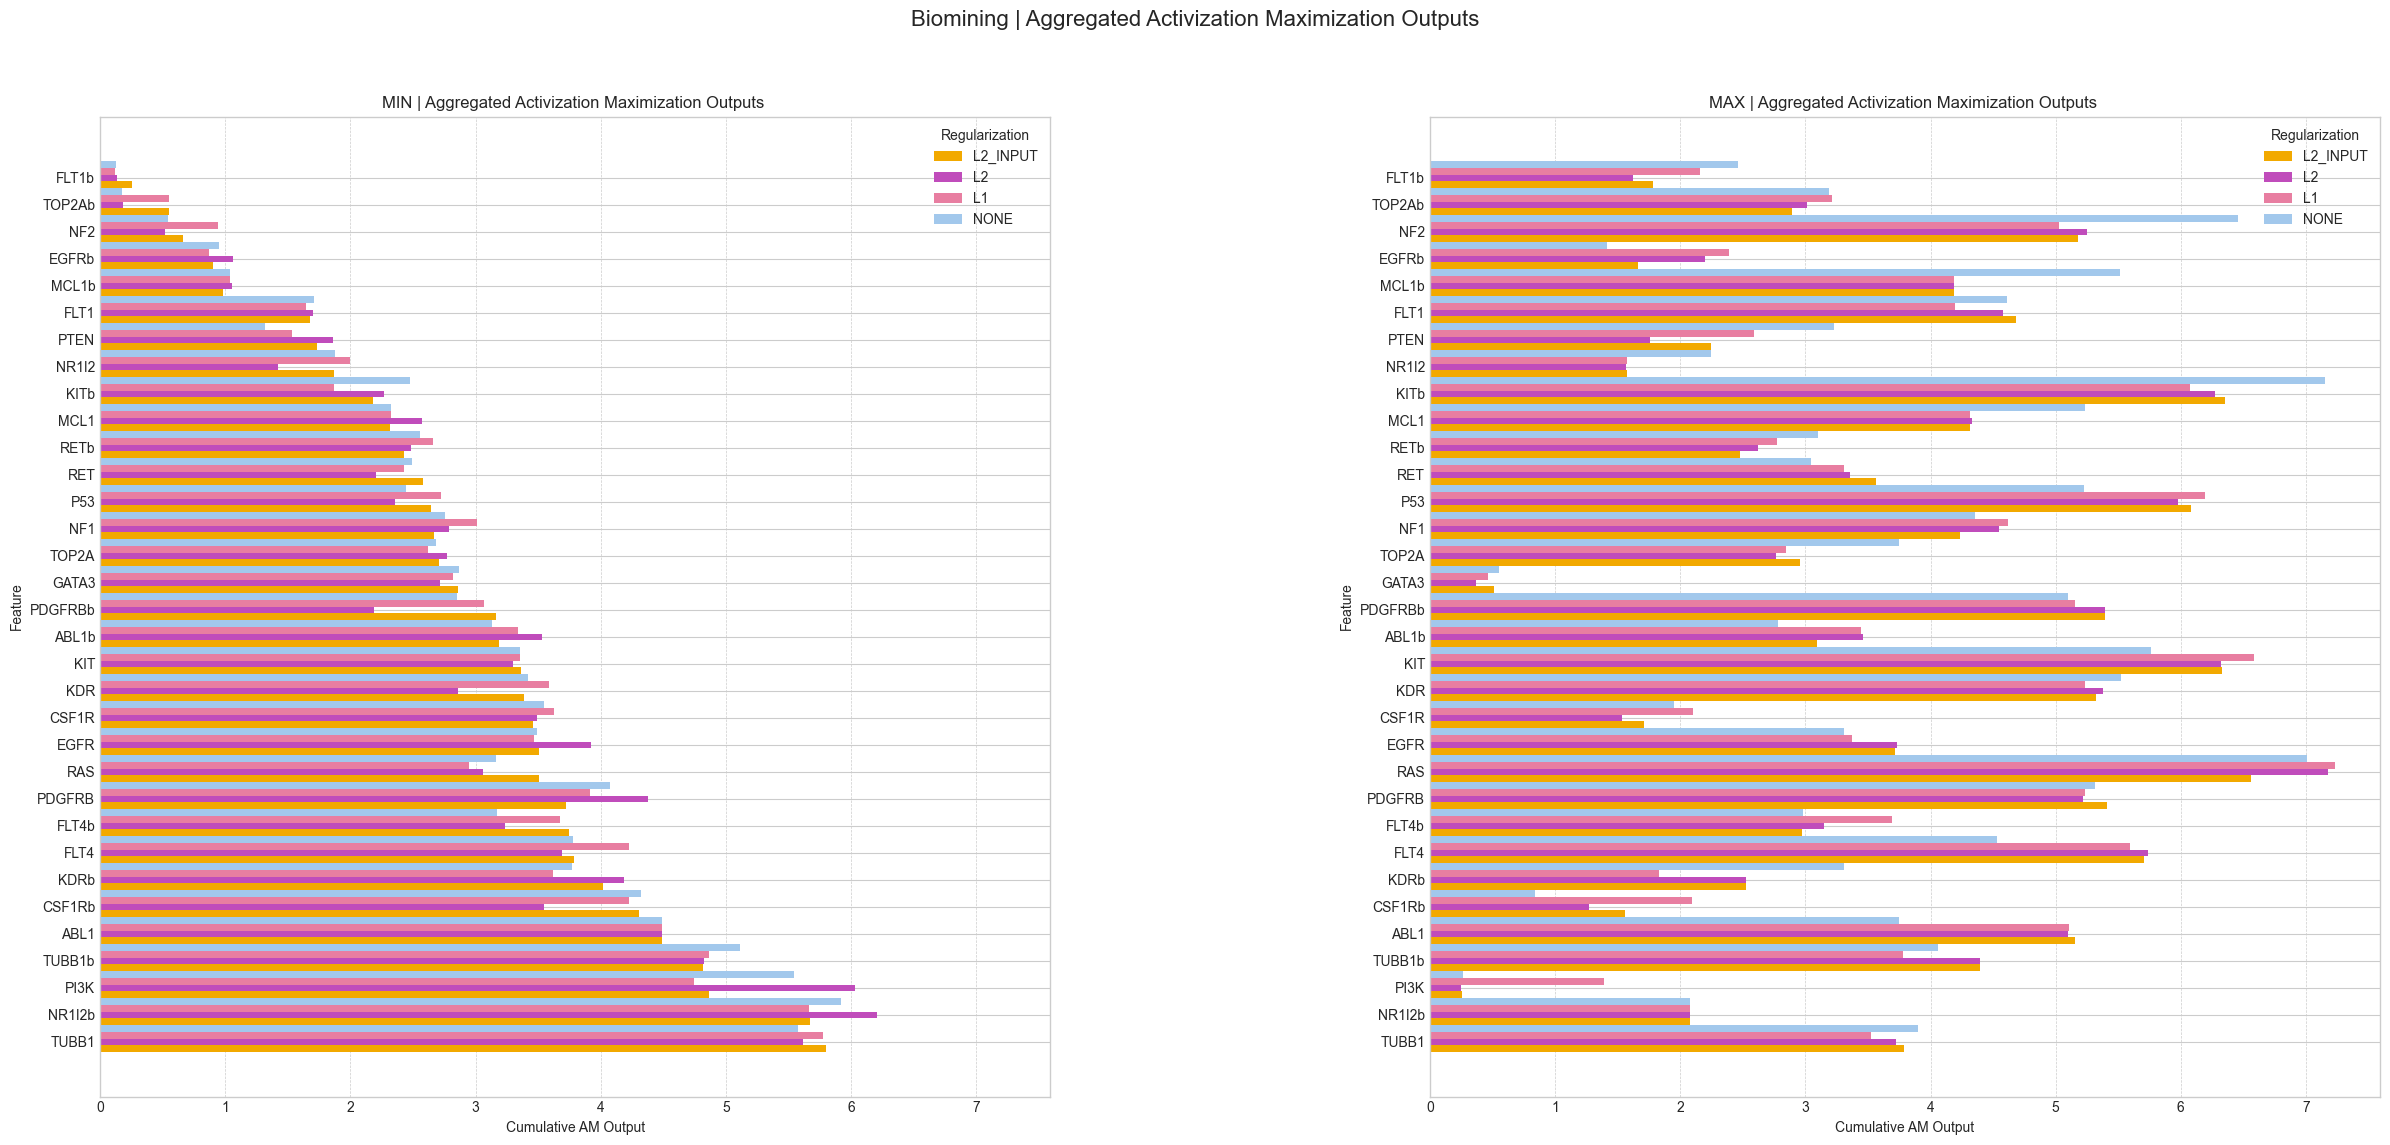

Sorting for transynergy | max | l2_input
Plotting for transynergy | max | (top25+bottom25)
Plotting for transynergy | min | (top25+bottom25)


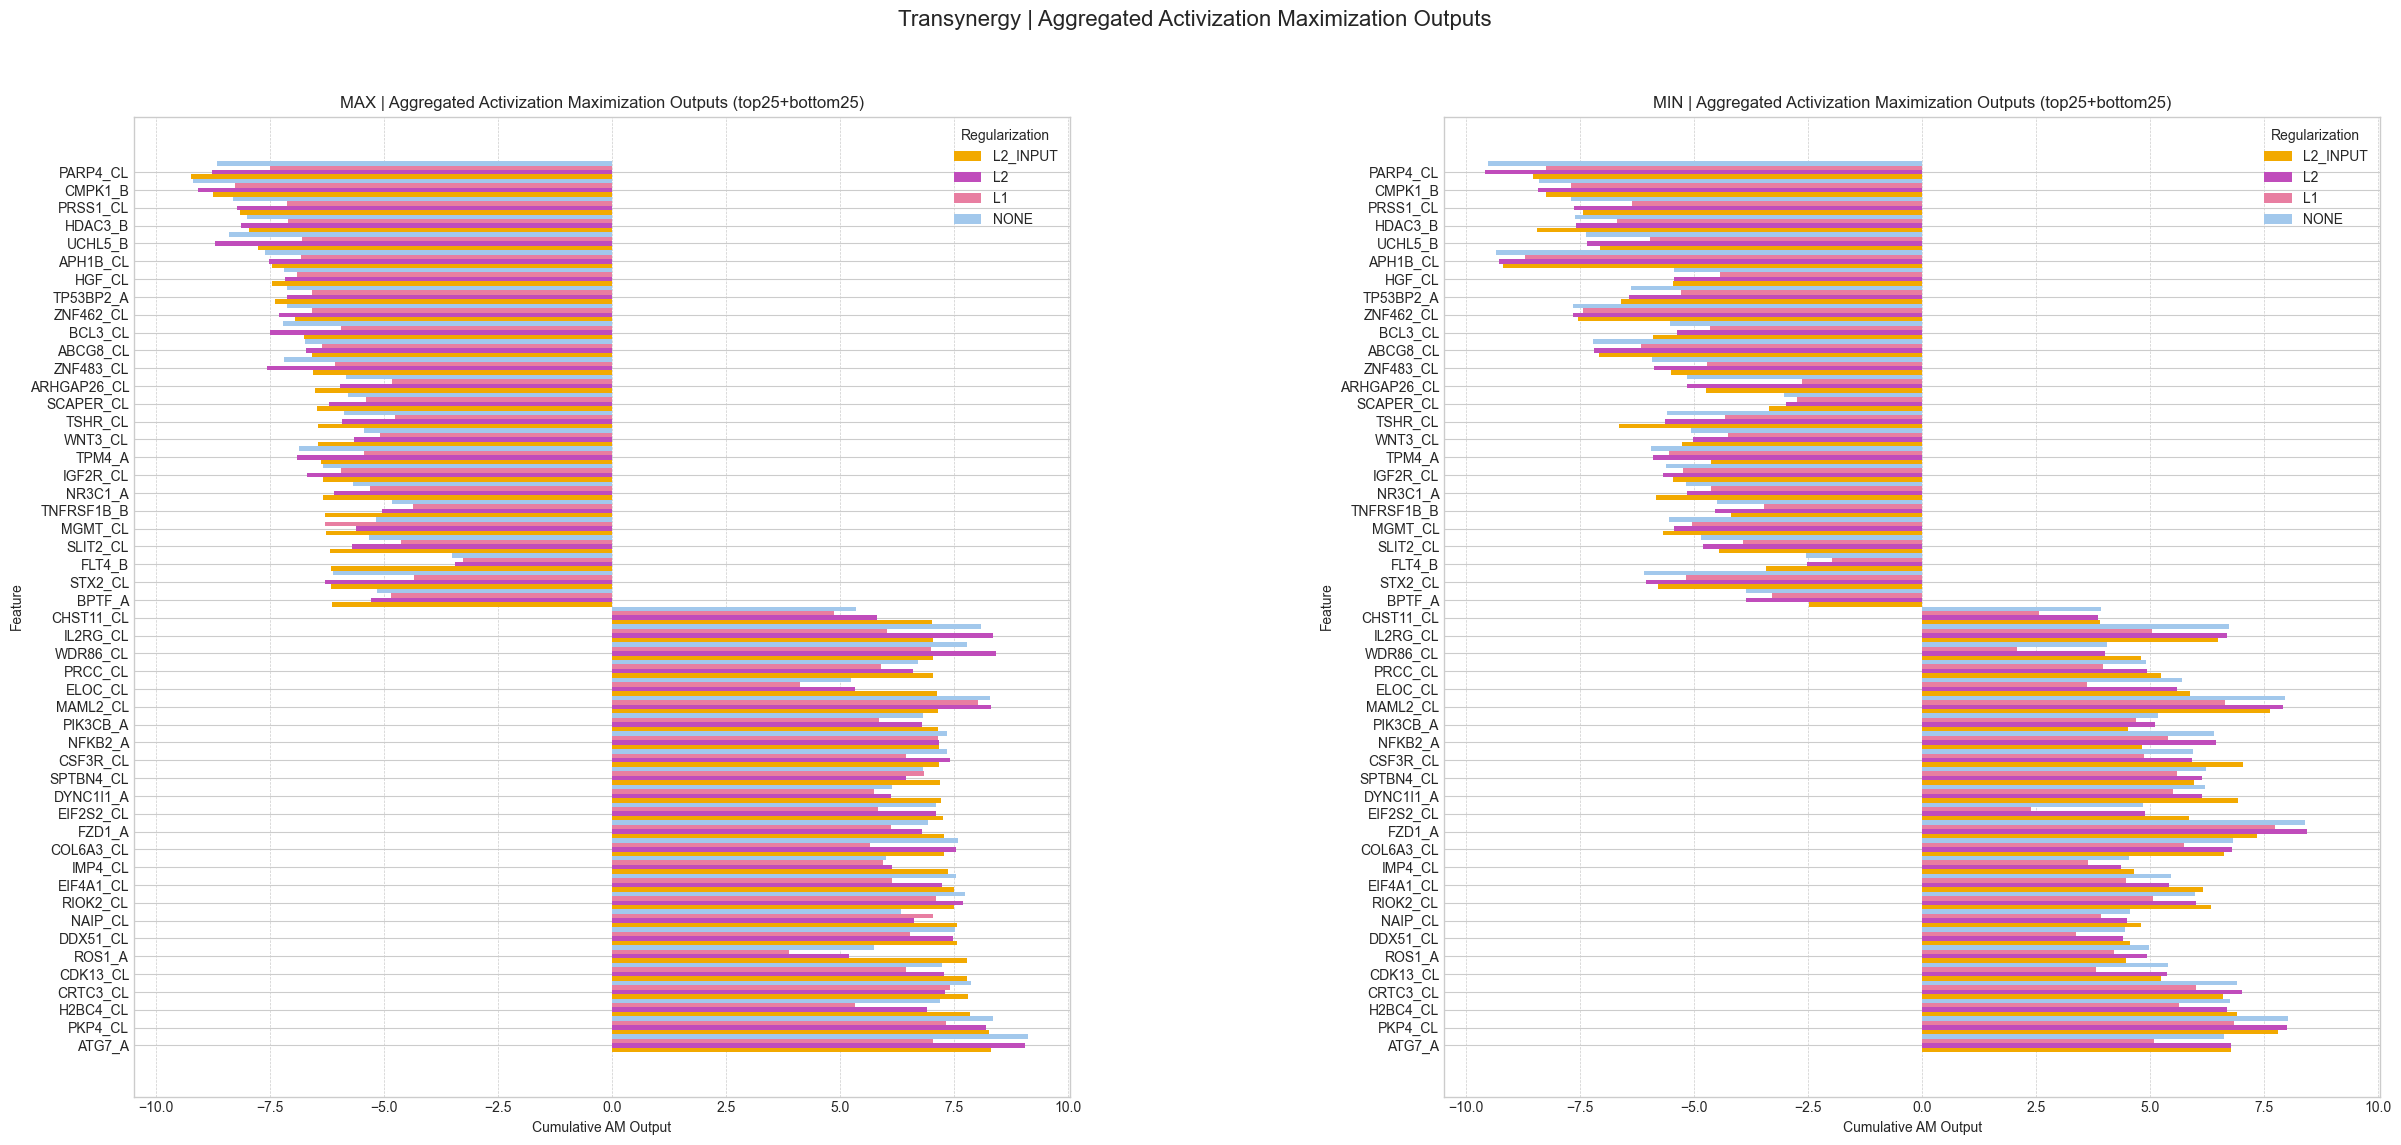

Sorting for transynergy | min | l2_input
Plotting for transynergy | min | (top25+bottom25)
Plotting for transynergy | max | (top25+bottom25)


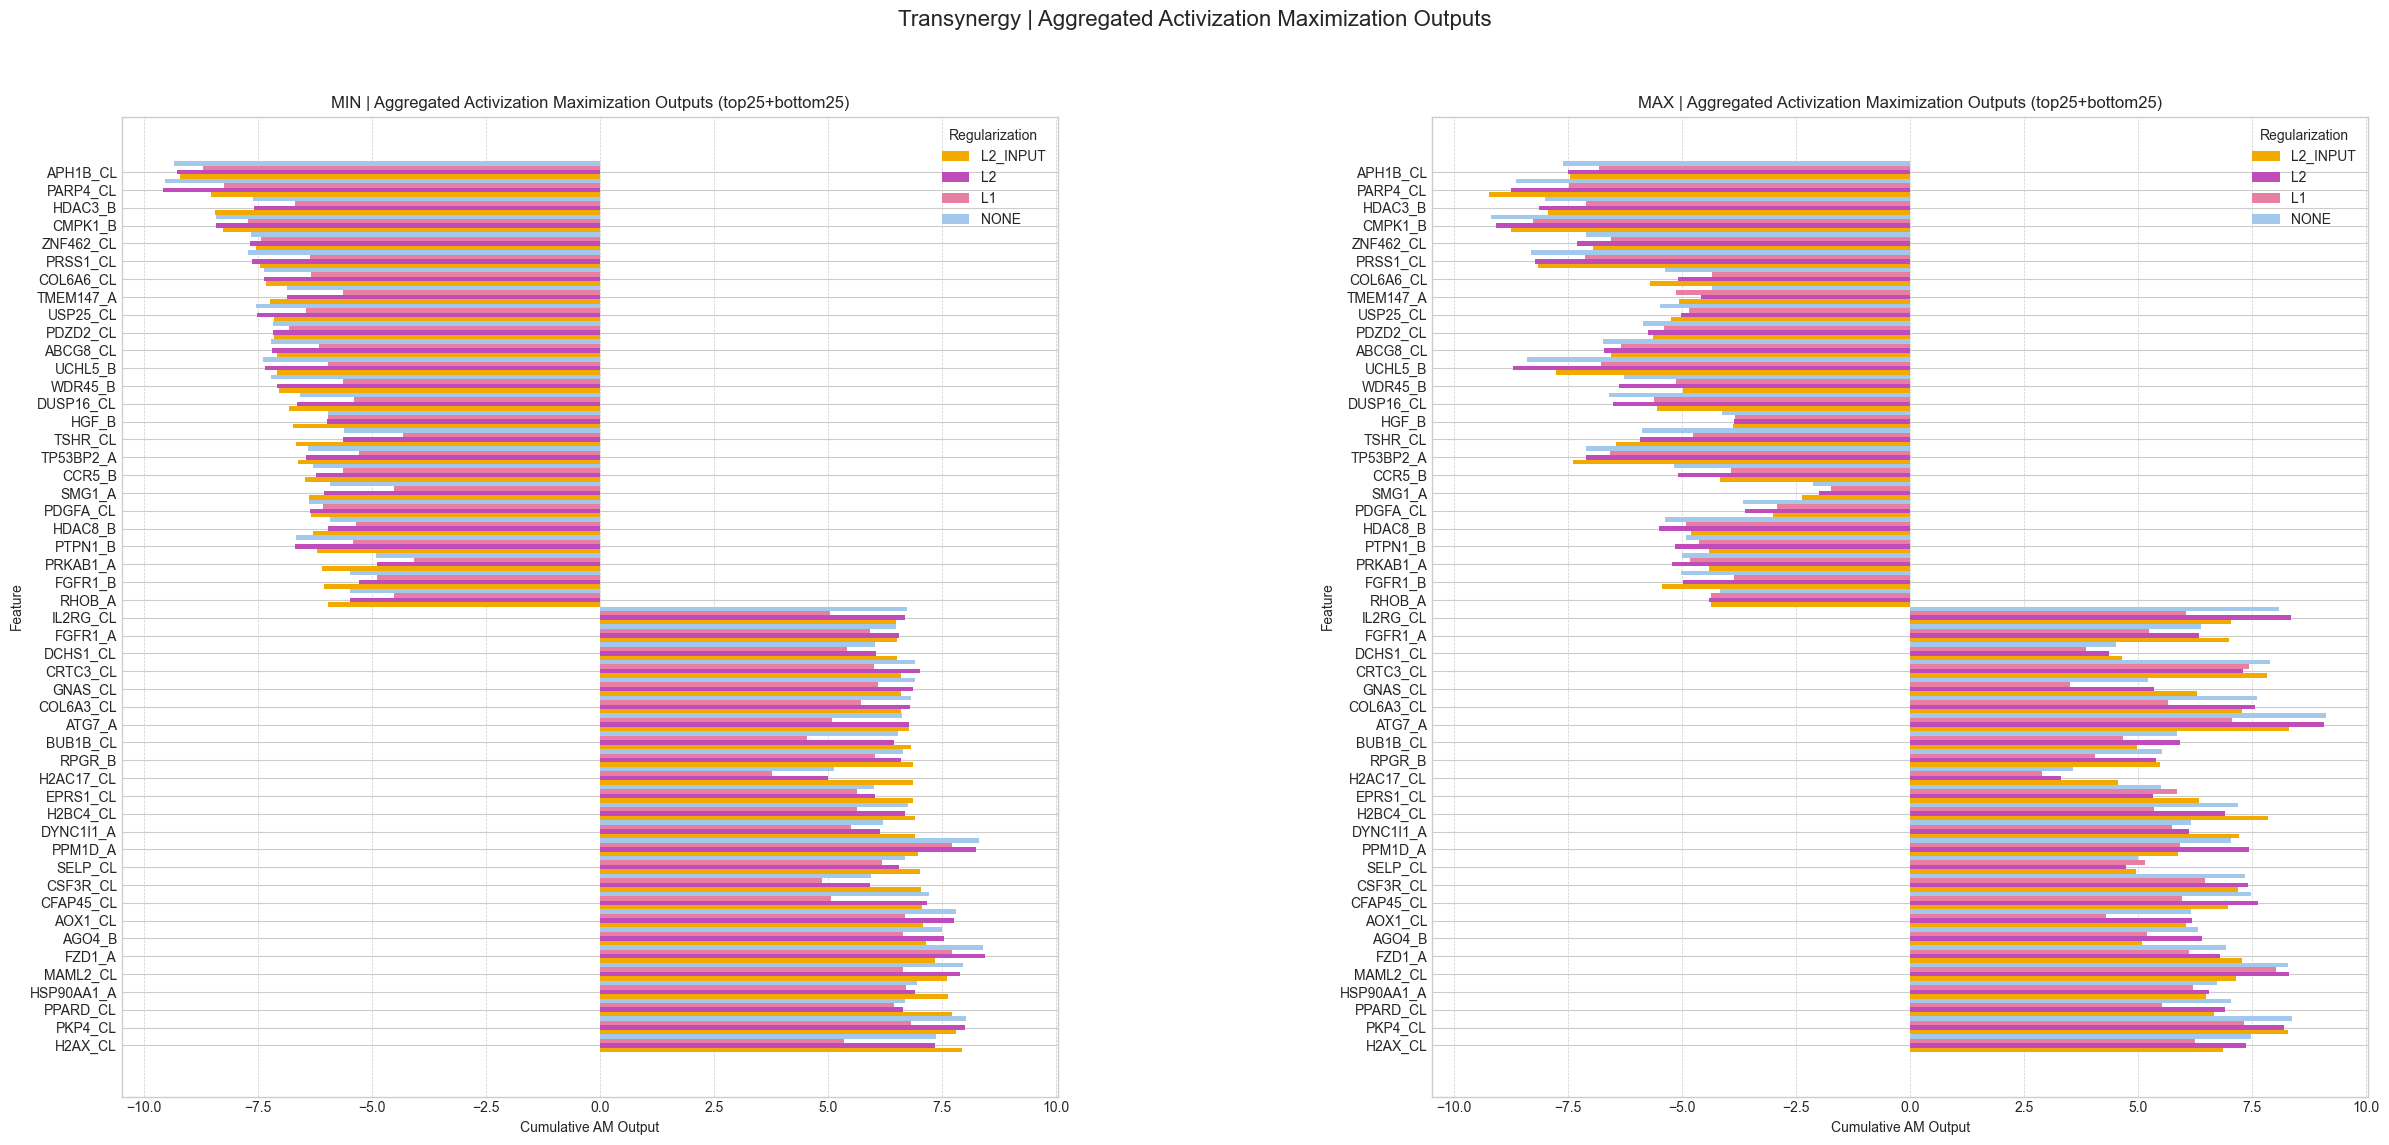

In [9]:
# now i kinda want to  do plots side by side of the minimization and maximization with the same fatures listed if that is possible and making the now x asis horizontal for the features to be listed on the y axis


for paper in papers:
    feature_names = ExplainationConfig(paper=paper).feature_names
    for minimaxis in [ ["max", "min"],  ["min", "max"]]:
        SORTED_ORDER_INDICES = None
        dict_papers_indices_l2 = {}
        fig, axes = plt.subplots(1, 2, figsize=(24, 12)) # Create subplots for min and max
        for ax_idx, minimax in enumerate(minimaxis):
            for reg in ["l2_input", "l1", "l2", "none"]:
                path_to_experiment = os.path.join(os.getcwd(), f"explainability/am/results/{paper}_{minimax}_reg_{reg}")

                feature_importance = torch.zeros(len(feature_names))
                for file in os.listdir(path_to_experiment):
                    if file.endswith(".pt"):
                        tensor = torch.load(os.path.join(path_to_experiment, file))
                        feature_importance += tensor

                importance_values = feature_importance.tolist()
                feature_importance_all_regs[reg] = importance_values

                if SORTED_ORDER_INDICES is None:
                    # Sort based on this reg (first one in loop)
                    print(f"Sorting for {paper} | {minimax} | {reg}")
                    full_sorted_indices = sorted(
                        range(len(importance_values)), key=lambda i: importance_values[i], reverse=True
                    )
                    dict_papers_indices_l2[(paper, minimax)] = full_sorted_indices
                    if len(feature_names) > 50:
                        # Take top 25 and bottom 25
                        top_25 = full_sorted_indices[:25]
                        bottom_25 = full_sorted_indices[-25:]
                        SORTED_ORDER_INDICES = top_25 + bottom_25
                    else:
                        SORTED_ORDER_INDICES = full_sorted_indices


            sorted_feature_names = [feature_names[i] for i in SORTED_ORDER_INDICES]

            bar_width = 0.25
            y = range(len(SORTED_ORDER_INDICES)) # Use y for horizontal bars

            for idx, reg in enumerate(regularizations):
                sorted_values = [feature_importance_all_regs[reg][i] for i in SORTED_ORDER_INDICES]
                offset = [yi + (idx - 1) * bar_width for yi in y] # shift bars
                axes[ax_idx].barh(offset, sorted_values, height=bar_width, label=reg.upper(), color=colors[reg]) # Use barh

            if len(feature_names) > 50:
                suffix = "(top25+bottom25)"
            else:
                suffix = ""
            print(f"Plotting for {paper} | {minimax} | {suffix}")
            axes[ax_idx].set_yticks(y) # Use set_yticks
            axes[ax_idx].set_yticklabels(sorted_feature_names) # Use set_yticklabels
            axes[ax_idx].set_title(f"{minimax.upper()} | Aggregated Activization Maximization Outputs {suffix}")
            axes[ax_idx].set_ylabel("Feature") # Swap labels
            axes[ax_idx].set_xlabel("Cumulative AM Output")
            axes[ax_idx].legend(title="Regularization")
            axes[ax_idx].grid(axis='x', linestyle='--', linewidth=0.5) # Change grid axis

        plt.suptitle(f"{paper.capitalize()} | Aggregated Activization Maximization Outputs", fontsize=16) # Overall title
        plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to accommodate overall title
        # make sure x axis have same scale (get the higher scale) acriss axis 
        
        # After plotting but before setting xlim
        max_x = max(ax.get_xlim()[1] for ax in axes)
        min_x = min(ax.get_xlim()[0] for ax in axes)
        for ax in axes:
            ax.set_xlim(min_x, max_x)
        plt.subplots_adjust(wspace=0.4)
        plt.show() 

We now did means of all of those features generated by the AM algorithm however this can be very much misleading, let's take a look at the variances of those featutures: are there some individual features that pretty much have a low variances ths are unchangily associated with either activization minimization or maximization? Let's take a look:)

## Variance in different regulariztions (across instances)

In [11]:
print("--- Variance Across Instances ---")

for paper in papers:
    feature_names = ExplainationConfig(paper=paper).feature_names
    num_features = len(feature_names)

    for minimax in minimaxis:
        print(f"\nPaper: {paper.capitalize()}, Minimax: {minimax.upper()}")

        for reg in regularizations:
            path_to_experiment = os.path.join(os.getcwd(), f"explainability/am/results/{paper}_{minimax}_reg_{reg}")

            individual_tensors = []
            if os.path.exists(path_to_experiment):
                for file in os.listdir(path_to_experiment):
                    if file.endswith(".pt"):
                        tensor = torch.load(os.path.join(path_to_experiment, file))
                        individual_tensors.append(tensor)

            if individual_tensors:
                # Stack all individual tensors to perform variance calculation
                stacked_tensors = torch.stack(individual_tensors) # Shape: (num_instances, num_features)

                # Calculate variance for each feature across instances
                # For torch.var, keepdim=False by default, so it will return a 1D tensor of variances per feature
                feature_variances = torch.var(stacked_tensors, dim=0).tolist() # Variance across the instance dimension (dim=0)

                print(f"  Regularization: {reg.upper()}")
                print(f"    Top 5 Features by Variance:")
                # Sort features by their variance
                sorted_variance_indices = sorted(range(num_features), key=lambda i: feature_variances[i], reverse=True)
                for i in range(min(5, num_features)):
                    idx = sorted_variance_indices[i]
                    print(f"      {feature_names[idx]}: {feature_variances[idx]:.4f}")
                
                print(f"    Bottom 5 Features by Variance:")
                for i in range(min(5, num_features)):
                    idx = sorted_variance_indices[-(i + 1)]
                    print(f"      {feature_names[idx]}: {feature_variances[idx]:.4f}")
            else:
                print(f"  Regularization: {reg.upper()} - No .pt files found in {path_to_experiment}")

--- Variance Across Instances ---

Paper: Biomining, Minimax: MIN
  Regularization: L2_INPUT
    Top 5 Features by Variance:
      PI3K: 0.9215
      ABL1: 0.6022
      RAS: 0.6004
      EGFR: 0.4379
      P53: 0.4332
    Bottom 5 Features by Variance:
      FLT1b: 0.0131
      TUBB1b: 0.0268
      TOP2Ab: 0.0278
      TUBB1: 0.0365
      PDGFRB: 0.0435
  Regularization: L2
    Top 5 Features by Variance:
      PI3K: 0.6508
      ABL1: 0.6053
      RAS: 0.4051
      MCL1: 0.3855
      RETb: 0.3842
    Bottom 5 Features by Variance:
      FLT1b: 0.0028
      TOP2Ab: 0.0064
      KDRb: 0.0111
      TUBB1b: 0.0377
      TUBB1: 0.0407
  Regularization: L1
    Top 5 Features by Variance:
      PI3K: 0.8780
      ABL1: 0.6012
      P53: 0.4689
      RETb: 0.4417
      EGFR: 0.4352
    Bottom 5 Features by Variance:
      FLT1b: 0.0027
      TUBB1b: 0.0224
      TOP2Ab: 0.0277
      KITb: 0.0323
      TUBB1: 0.0354
  Regularization: NONE
    Top 5 Features by Variance:
      PI3K: 0.6884
    

### Variance across regularizations

In [13]:


regularizations = ["l2_input", "l2", "l1", "none"]
minimaxis = ["max", "min"]
papers = ["biomining", "transynergy"]

print("\n\n--- Variance Across Regularizations ---")

for paper in papers:
    feature_names = ExplainationConfig(paper=paper).feature_names
    num_features = len(feature_names)

    for minimax in minimaxis:
        print(f"\nPaper: {paper.capitalize()}, Minimax: {minimax.upper()}")

        feature_importance_all_regs = {} # Reset for each paper/minimax combination

        for reg in regularizations:
            path_to_experiment = os.path.join(os.getcwd(), f"explainability/am/results/{paper}_{minimax}_reg_{reg}")
            feature_importance = torch.zeros(len(feature_names))

            if os.path.exists(path_to_experiment):
                for file in os.listdir(path_to_experiment):
                    if file.endswith(".pt"):
                        tensor = torch.load(os.path.join(path_to_experiment, file))
                        feature_importance += tensor 
                feature_importance_all_regs[reg] = feature_importance.tolist()
            else:
                print(f"  Warning: No data for {paper}_{minimax}_reg_{reg}. Skipping.")
                feature_importance_all_regs[reg] = [0.0] * num_features # Fill with zeros to avoid errors

        if len(feature_importance_all_regs) == len(regularizations) and all(v is not None for v in feature_importance_all_regs.values()):
            # Create a tensor where each row is the feature importance for a different regularization
            reg_values_for_variance = torch.tensor([feature_importance_all_regs[reg_key] for reg_key in regularizations])
            # Shape: (num_regularizations, num_features)

            # Calculate variance for each feature across different regularizations
            feature_variances_across_regs = torch.var(reg_values_for_variance, dim=0).tolist()

            print(f"  Variance of Feature Importance Across Regularizations:")
            print(f"    Top 5 Features by Variance:")
            sorted_variance_indices = sorted(range(num_features), key=lambda i: feature_variances_across_regs[i], reverse=True)
            for i in range(min(5, num_features)):
                idx = sorted_variance_indices[i]
                print(f"      {feature_names[idx]}: {feature_variances_across_regs[idx]:.4f}")
            
            
            print(f"    Bottom 5 Features by Variance:")
            for i in range(min(5, num_features)):
                idx = sorted_variance_indices[-(i + 1)]
                print(f"      {feature_names[idx]}: {feature_variances_across_regs[idx]:.4f}")
        else:
            print(f"  Not enough data to calculate variance across regularizations for {paper.capitalize()}, {minimax.upper()}")



--- Variance Across Regularizations ---

Paper: Biomining, Minimax: MAX
  Variance of Feature Importance Across Regularizations:
    Top 5 Features by Variance:
      ABL1: 0.4741
      MCL1b: 0.4417
      NF2: 0.4318
      PTEN: 0.3815
      KDRb: 0.3643
    Bottom 5 Features by Variance:
      NR1I2b: 0.0000
      GATA3: 0.0063
      PDGFRB: 0.0079
      KDR: 0.0141
      TOP2Ab: 0.0233

Paper: Biomining, Minimax: MIN
  Variance of Feature Importance Across Regularizations:
    Top 5 Features by Variance:
      PI3K: 0.3635
      PDGFRBb: 0.1944
      CSF1Rb: 0.1363
      KDR: 0.0986
      FLT4b: 0.0878
    Bottom 5 Features by Variance:
      ABL1: 0.0000
      FLT1: 0.0008
      KIT: 0.0010
      MCL1b: 0.0011
      TOP2A: 0.0038

Paper: Transynergy, Minimax: MAX
  Variance of Feature Importance Across Regularizations:
    Top 5 Features by Variance:
      OR2W3_A: 13.6412
      PXMP4_B: 10.8681
      ANKRD26_A: 10.4429
      PRKDC_CL: 10.3845
      BNC2_A: 10.3273
    Bottom 5 F

In [16]:
import os
import torch
import numpy as np # Import numpy for variance calculation
import matplotlib.pyplot as plt
from explaination_config import ExplainationConfig


regularizations = ["l2_input", "l2", "l1", "none"]
minimaxis = ["max", "min"]
papers = ["biomining", "transynergy"]

print("\n\n--- Total Variance ---")

for paper in papers:
    feature_names = ExplainationConfig(paper=paper).feature_names
    num_features = len(feature_names)

    for minimax in minimaxis:
        print(f"\nPaper: {paper.capitalize()}, Minimax: {minimax.upper()}")

        feature_importance_all_regs = {} # Reset for each paper/minimax combination

        for reg in regularizations:
            path_to_experiment = os.path.join(os.getcwd(), f"explainability/am/results/{paper}_{minimax}_reg_{reg}")
            feature_importance = None
            if os.path.exists(path_to_experiment):
                for file in os.listdir(path_to_experiment):
                    if file.endswith(".pt"):
                        tensor = torch.load(os.path.join(path_to_experiment, file))
                        if feature_importance is not None:
                            feature_importance = torch.cat([tensor.unsqueeze(0), feature_importance], dim=0)
                        else:
                            feature_importance = tensor.unsqueeze(0)
                feature_importance_all_regs[reg] = feature_importance
            else:
                print(f"  Warning: No data for {paper}_{minimax}_reg_{reg}. Skipping.")
                feature_importance_all_regs[reg] = [0.0] * num_features # Fill with zeros to avoid errors

        if len(feature_importance_all_regs) == len(regularizations):
            # Create a tensor where each row is the feature importance for a different regularization
            reg_values_for_variance = torch.cat([feature_importance_all_regs[reg_key] for reg_key in regularizations], dim =0)
            # Shape: (num_regularizations, num_features)
            print(f"  Shape of reg_values_for_variance: {reg_values_for_variance.shape}")

            # Calculate variance for each feature across different regularizations
            feature_variances_across_regs = torch.var(reg_values_for_variance, dim=0).tolist()

            print(f"  Variance of Feature Importance Across Regularizations:")
            print(f"    Top 5 Features by Variance:")
            sorted_variance_indices = sorted(range(num_features), key=lambda i: feature_variances_across_regs[i], reverse=True)
            for i in range(min(5, num_features)):
                idx = sorted_variance_indices[i]
                print(f"      {feature_names[idx]}: {feature_variances_across_regs[idx]:.4f}")
            
            
            print(f"    Bottom 5 Features by Variance:")
            for i in range(min(5, num_features)):
                idx = sorted_variance_indices[-(i + 1)]
                print(f"      {feature_names[idx]}: {feature_variances_across_regs[idx]:.4f}")
        else:
            print(f"  Not enough data to calculate variance across regularizations for {paper.capitalize()}, {minimax.upper()}")



--- Total Variance ---

Paper: Biomining, Minimax: MAX
  Shape of reg_values_for_variance: torch.Size([20, 33])
  Variance of Feature Importance Across Regularizations:
    Top 5 Features by Variance:
      FLT4b: 0.5811
      RETb: 0.4870
      MCL1b: 0.4836
      PTEN: 0.4405
      RAS: 0.4027
    Bottom 5 Features by Variance:
      GATA3: 0.0191
      FLT1: 0.0334
      PDGFRB: 0.0376
      PI3K: 0.0645
      TUBB1b: 0.0767

Paper: Biomining, Minimax: MIN
  Shape of reg_values_for_variance: torch.Size([20, 33])
  Variance of Feature Importance Across Regularizations:
    Top 5 Features by Variance:
      PI3K: 0.6722
      ABL1: 0.5078
      MCL1: 0.3544
      RAS: 0.3536
      EGFR: 0.3463
    Bottom 5 Features by Variance:
      FLT1b: 0.0047
      TOP2Ab: 0.0158
      TUBB1b: 0.0245
      TUBB1: 0.0313
      KDRb: 0.0370

Paper: Transynergy, Minimax: MAX
  Shape of reg_values_for_variance: torch.Size([20, 7206])
  Variance of Feature Importance Across Regularizations:
    Top 

Generating 'Total Variance' plots (with top25/bottom25 logic) and storing variances by feature name...

Processing Biomining | MAX for total variance...
  Shape of combined_feature_data for variance calculation: torch.Size([20, 33])
  Stored total variances for Biomining | MAX by feature name.


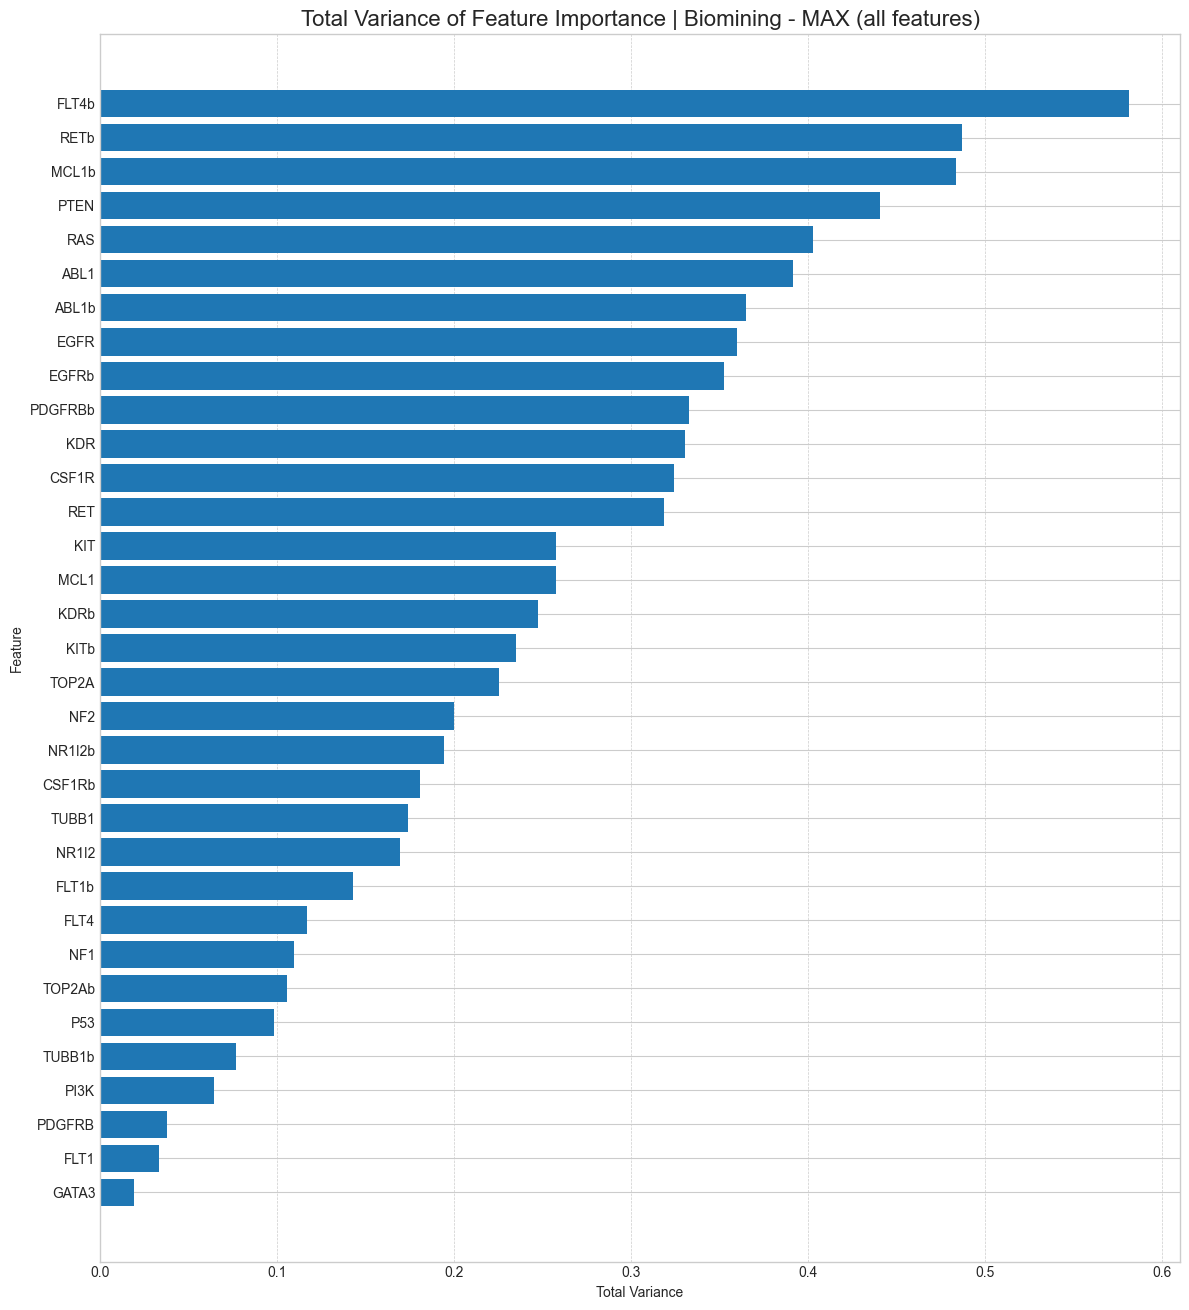


Processing Biomining | MIN for total variance...
  Shape of combined_feature_data for variance calculation: torch.Size([20, 33])
  Stored total variances for Biomining | MIN by feature name.


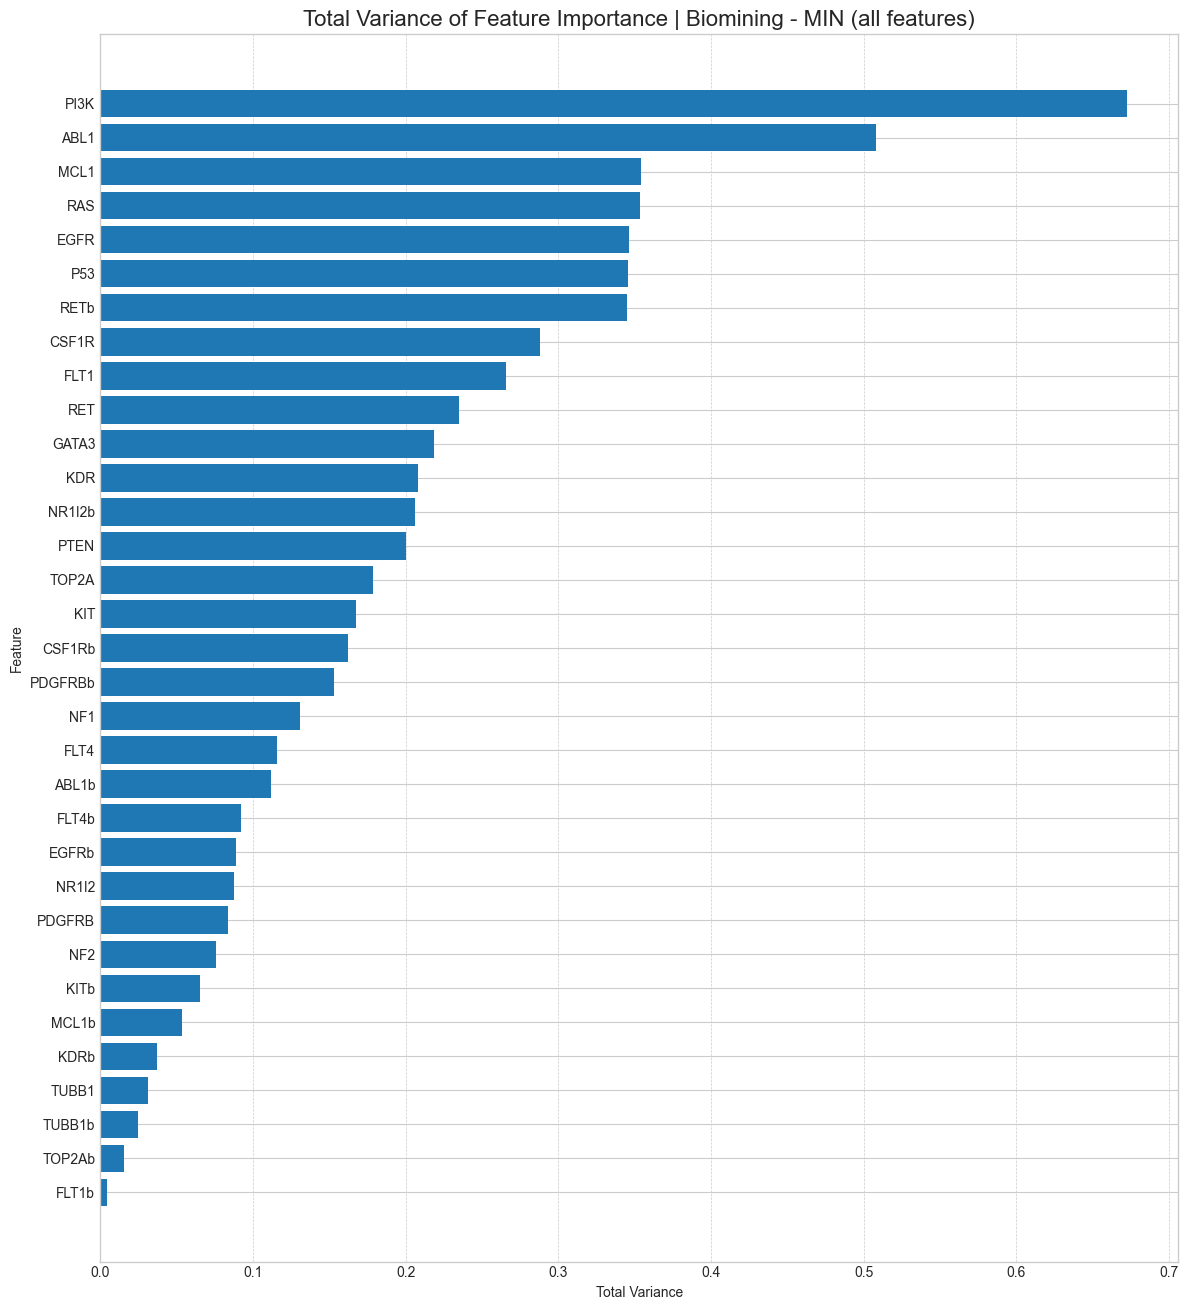


Processing Transynergy | MAX for total variance...
  Shape of combined_feature_data for variance calculation: torch.Size([20, 7206])
  Stored total variances for Transynergy | MAX by feature name.


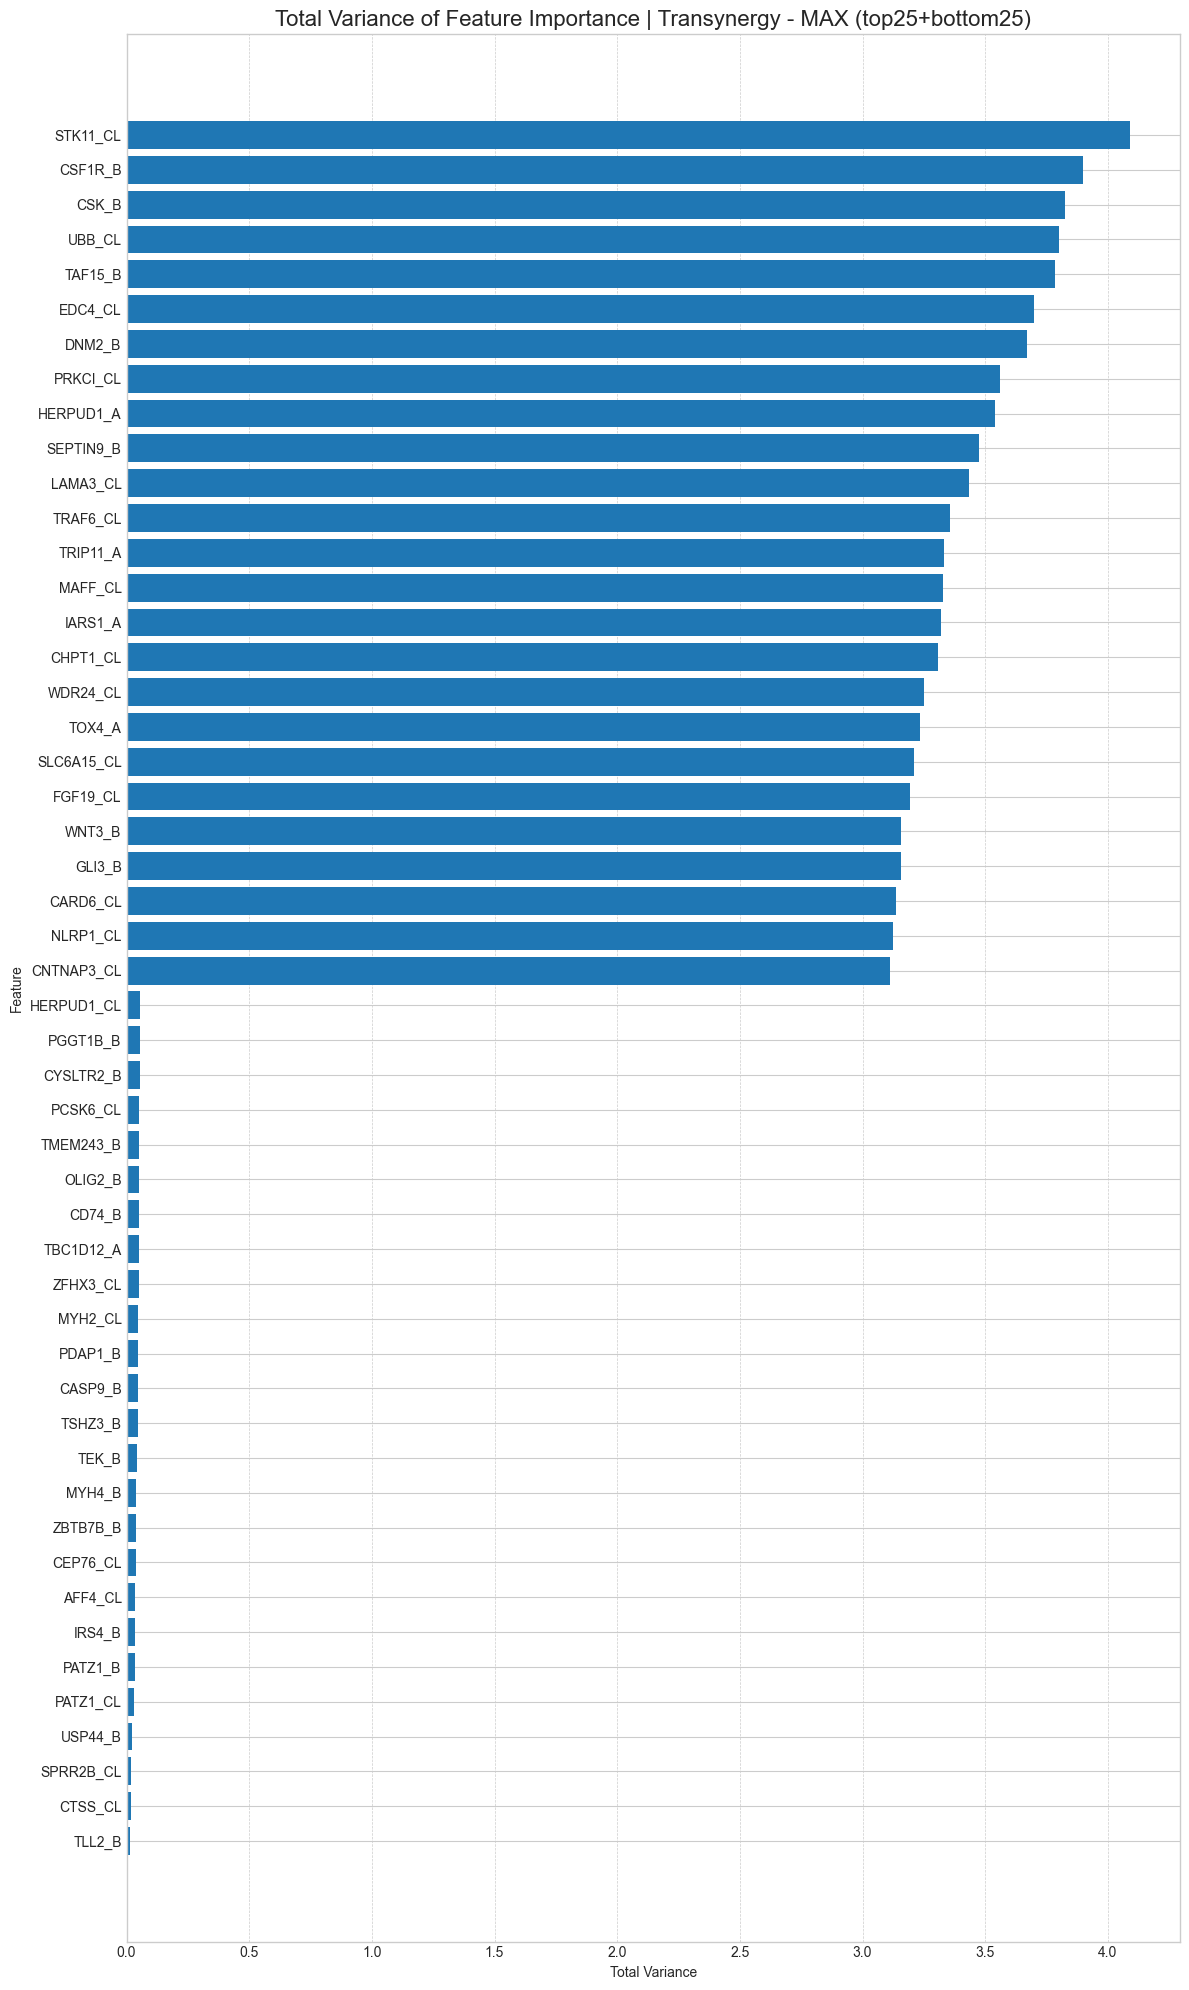


Processing Transynergy | MIN for total variance...
  Shape of combined_feature_data for variance calculation: torch.Size([20, 7206])
  Stored total variances for Transynergy | MIN by feature name.


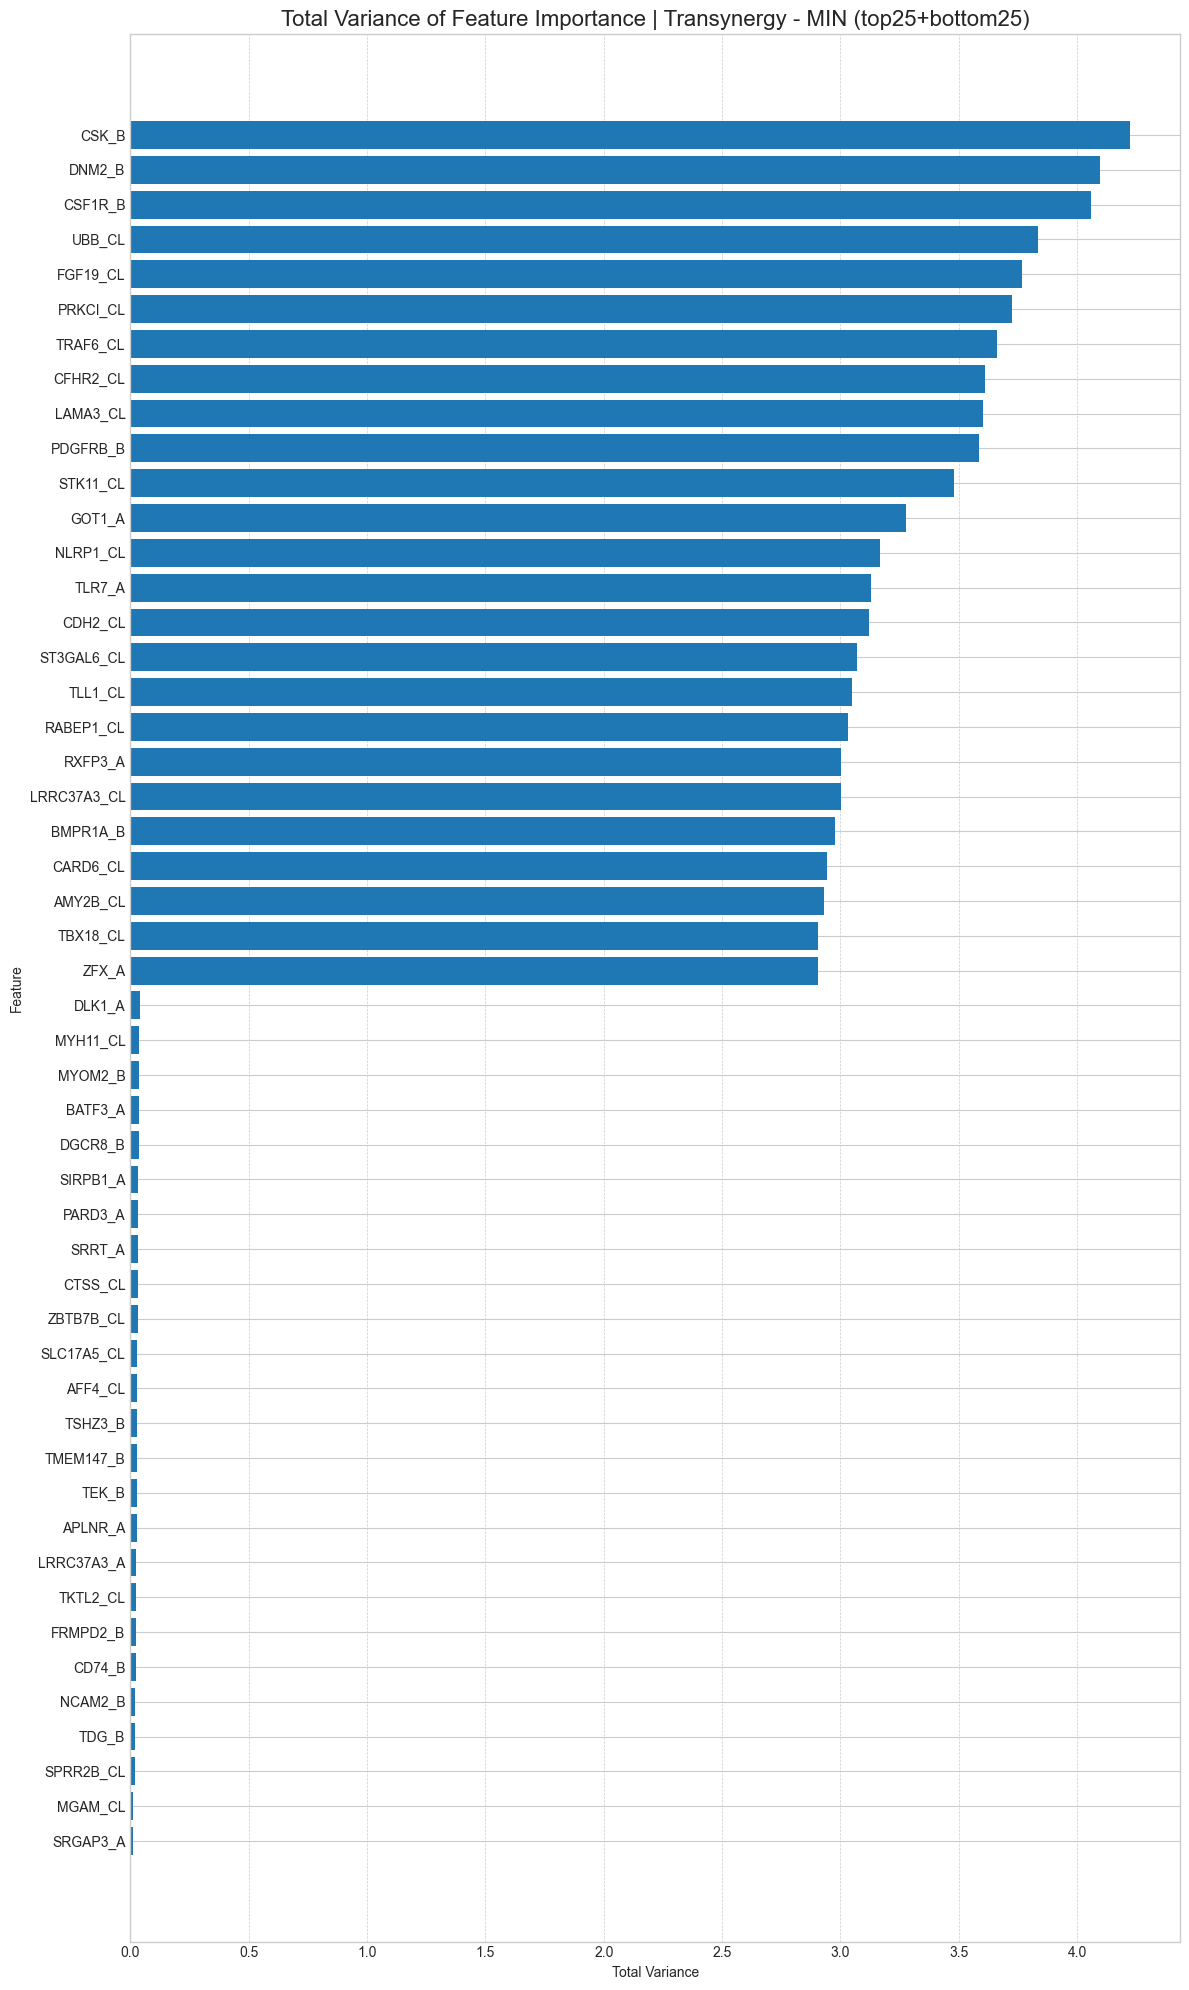


'Total Variance' plots generated and variances stored by feature name.

--- Example of accessing stored total variances by feature name ---
Accessing variances for Paper: biomining, Minimax: max
  Variance of 'ABL1': 0.3917
Accessing variances for Paper: biomining, Minimax: min
  Variance of 'ABL1': 0.5078
Accessing variances for Paper: transynergy, Minimax: max
  Variance of 'GDF5_A': 0.2035
Accessing variances for Paper: transynergy, Minimax: min
  Variance of 'GDF5_A': 0.4243


In [ ]:
regularizations = ["l2_input", "l2", "l1", "none"]
minimaxis = ["max", "min"]
papers = ["biomining", "transynergy"]

total_variances_by_config = {}

print("Generating 'Total Variance' plots (with top25/bottom25 logic) and storing variances by feature name...")

for paper in papers:
    feature_names = ExplainationConfig(paper=paper).feature_names
    num_features = len(feature_names)

    for minimax in minimaxis:
        all_individual_tensors_for_total_variance = []

        print(f"\nProcessing {paper.capitalize()} | {minimax.upper()} for total variance...")

        for reg in regularizations:
            path_to_experiment = os.path.join(os.getcwd(), f"explainability/am/results/{paper}_{minimax}_reg_{reg}")

            if os.path.exists(path_to_experiment):
                for file in os.listdir(path_to_experiment):
                    if file.endswith(".pt"):
                        tensor = torch.load(os.path.join(path_to_experiment, file))
                        all_individual_tensors_for_total_variance.append(tensor.unsqueeze(0))
            else:
                print(f"  Warning: Path not found for {paper}_{minimax}_reg_{reg}. Skipping files from this config.")

        if all_individual_tensors_for_total_variance:
            combined_feature_data = torch.cat(all_individual_tensors_for_total_variance, dim=0)
            print(f"  Shape of combined_feature_data for variance calculation: {combined_feature_data.shape}")

            total_feature_variances = torch.var(combined_feature_data, dim=0).tolist()

            feature_variance_map = {
                feature_names[i]: total_feature_variances[i] for i in range(num_features)
            }
            total_variances_by_config[(paper, minimax)] = feature_variance_map
            print(f"  Stored total variances for {paper.capitalize()} | {minimax.upper()} by feature name.")

            sorted_variance_items = sorted(feature_variance_map.items(), key=lambda item: item[1], reverse=True)
            # sorted_variance_items is a list of (feature_name, variance_value) tuples

            suffix = ""
            features_to_plot_names = []
            features_to_plot_variances = []

            if num_features > 50:
                # Take top 25 and bottom 25
                top_25_items = sorted_variance_items[:25]
                bottom_25_items = sorted_variance_items[max(0, num_features - 25):]
                features_to_plot_items = top_25_items + bottom_25_items
                suffix = "(top25+bottom25)"
            else:
                # If 50 or fewer features, plot all
                features_to_plot_items = sorted_variance_items
                suffix = "(all features)"

            # Extract names and variances for plotting
            plot_feature_names = [item[0] for item in features_to_plot_items]
            plot_variances = [item[1] for item in features_to_plot_items]


            # --- Plotting ---
            plt.figure(figsize=(12, max(8, len(plot_feature_names) * 0.4))) # Dynamic height
            y_pos = np.arange(len(plot_feature_names))
            plt.barh(y_pos, plot_variances, color='#1f77b4')

            plt.yticks(y_pos, plot_feature_names)
            plt.gca().invert_yaxis() # Highest variance feature at the top

            plt.title(f'Total Variance of Feature Importance | {paper.capitalize()} - {minimax.upper()} {suffix}', fontsize=16)
            plt.xlabel('Total Variance')
            plt.ylabel('Feature')
            plt.grid(axis='x', linestyle='--', linewidth=0.5)
            plt.tight_layout()
            plt.show()
        else:
            print(f"  No data found to calculate total variance for {paper.capitalize()} | {minimax.upper()}.")

print("\n'Total Variance' plots generated and variances stored by feature name.")

# --- Example of how to access the stored variances by feature name ---
print("\n--- Example of accessing stored total variances by feature name ---")
for (paper_key, minimax_key), feature_variance_map in total_variances_by_config.items():
    print(f"Accessing variances for Paper: {paper_key}, Minimax: {minimax_key}")
    # You can now access variances directly by feature name
    if feature_variance_map:
        # Get the first feature name (arbitrary example)
        first_feature_name = next(iter(feature_variance_map))
        print(f"  Variance of '{first_feature_name}': {feature_variance_map[first_feature_name]:.4f}")

        # Or, iterate through all features and their variances
        # for feature, variance in feature_variance_map.items():
        #     print(f"  '{feature}': {variance:.4f}")
    else:
        print("  No variances stored for this configuration.")

## Analaysis of variance andmagnitude of AM features in the L1 input-regularised case

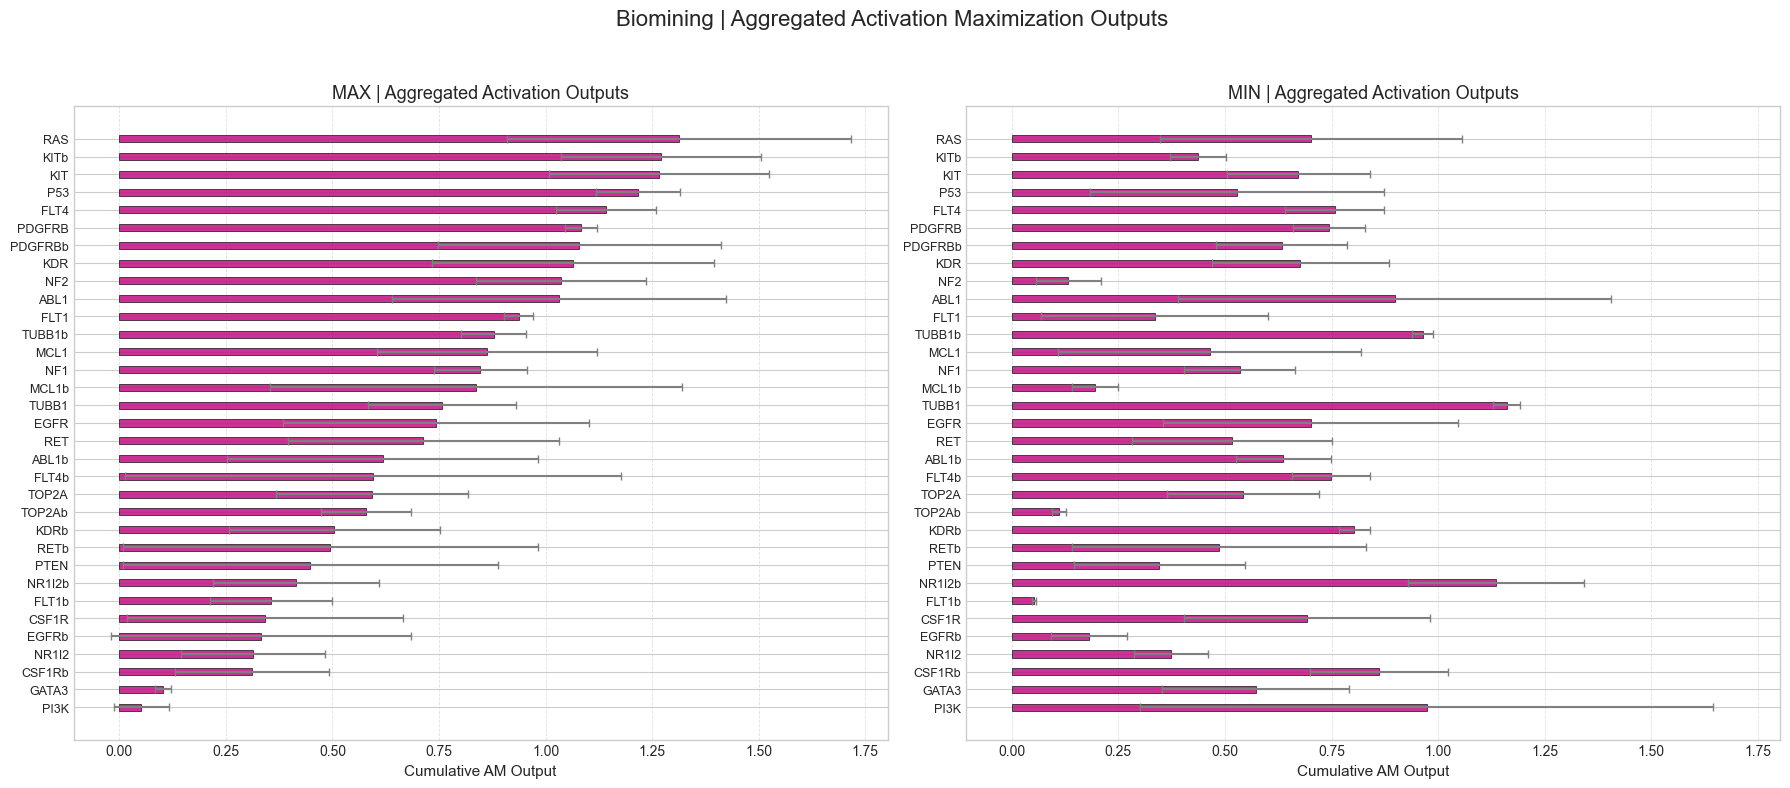

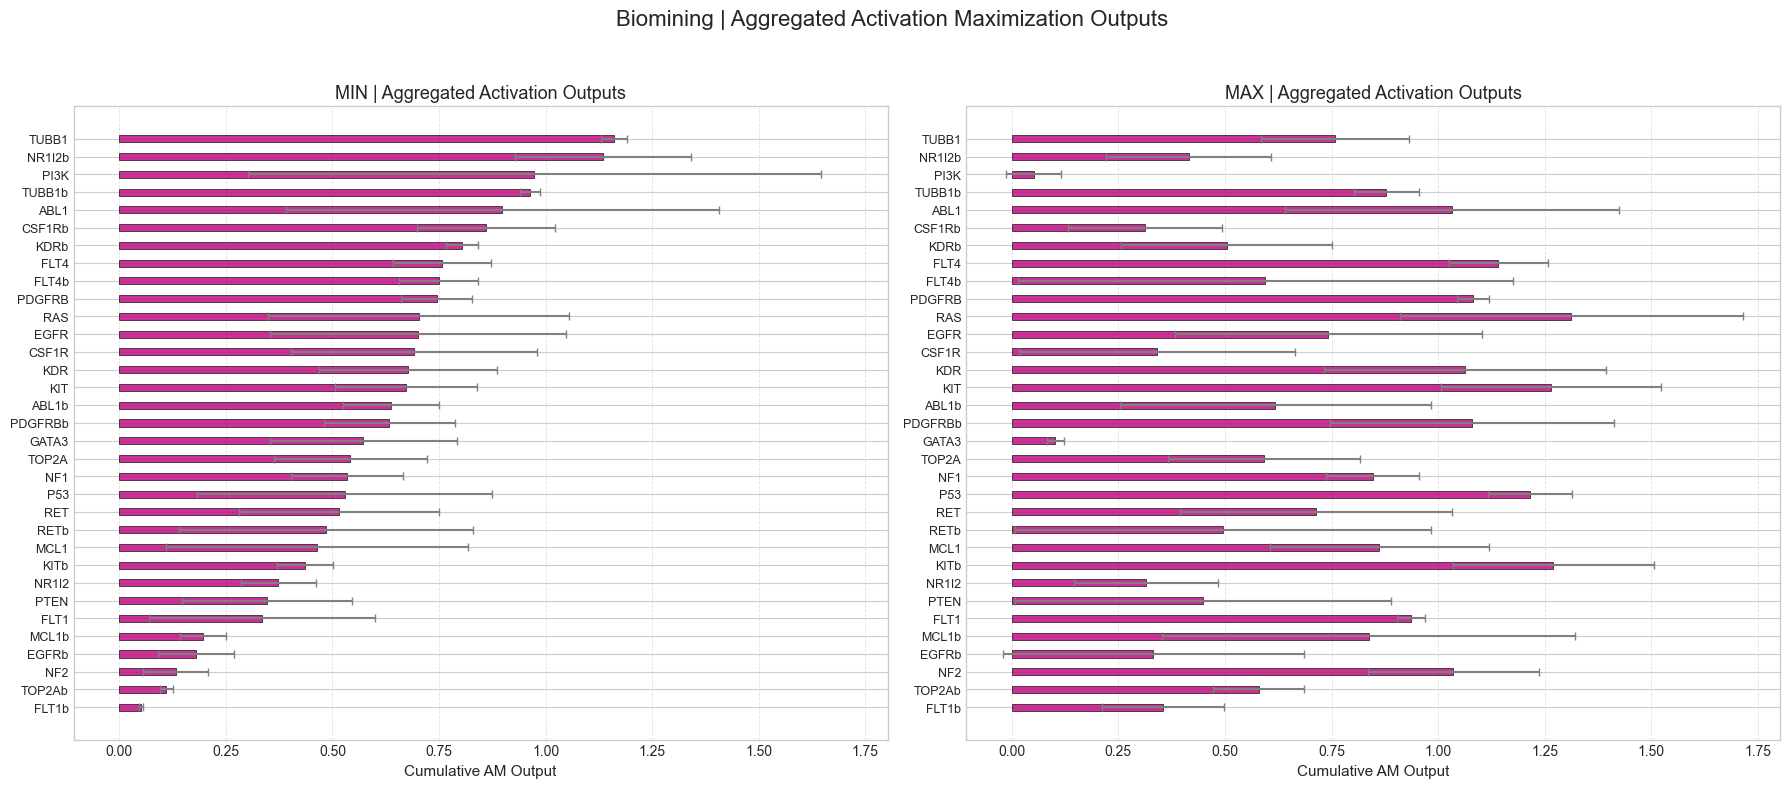

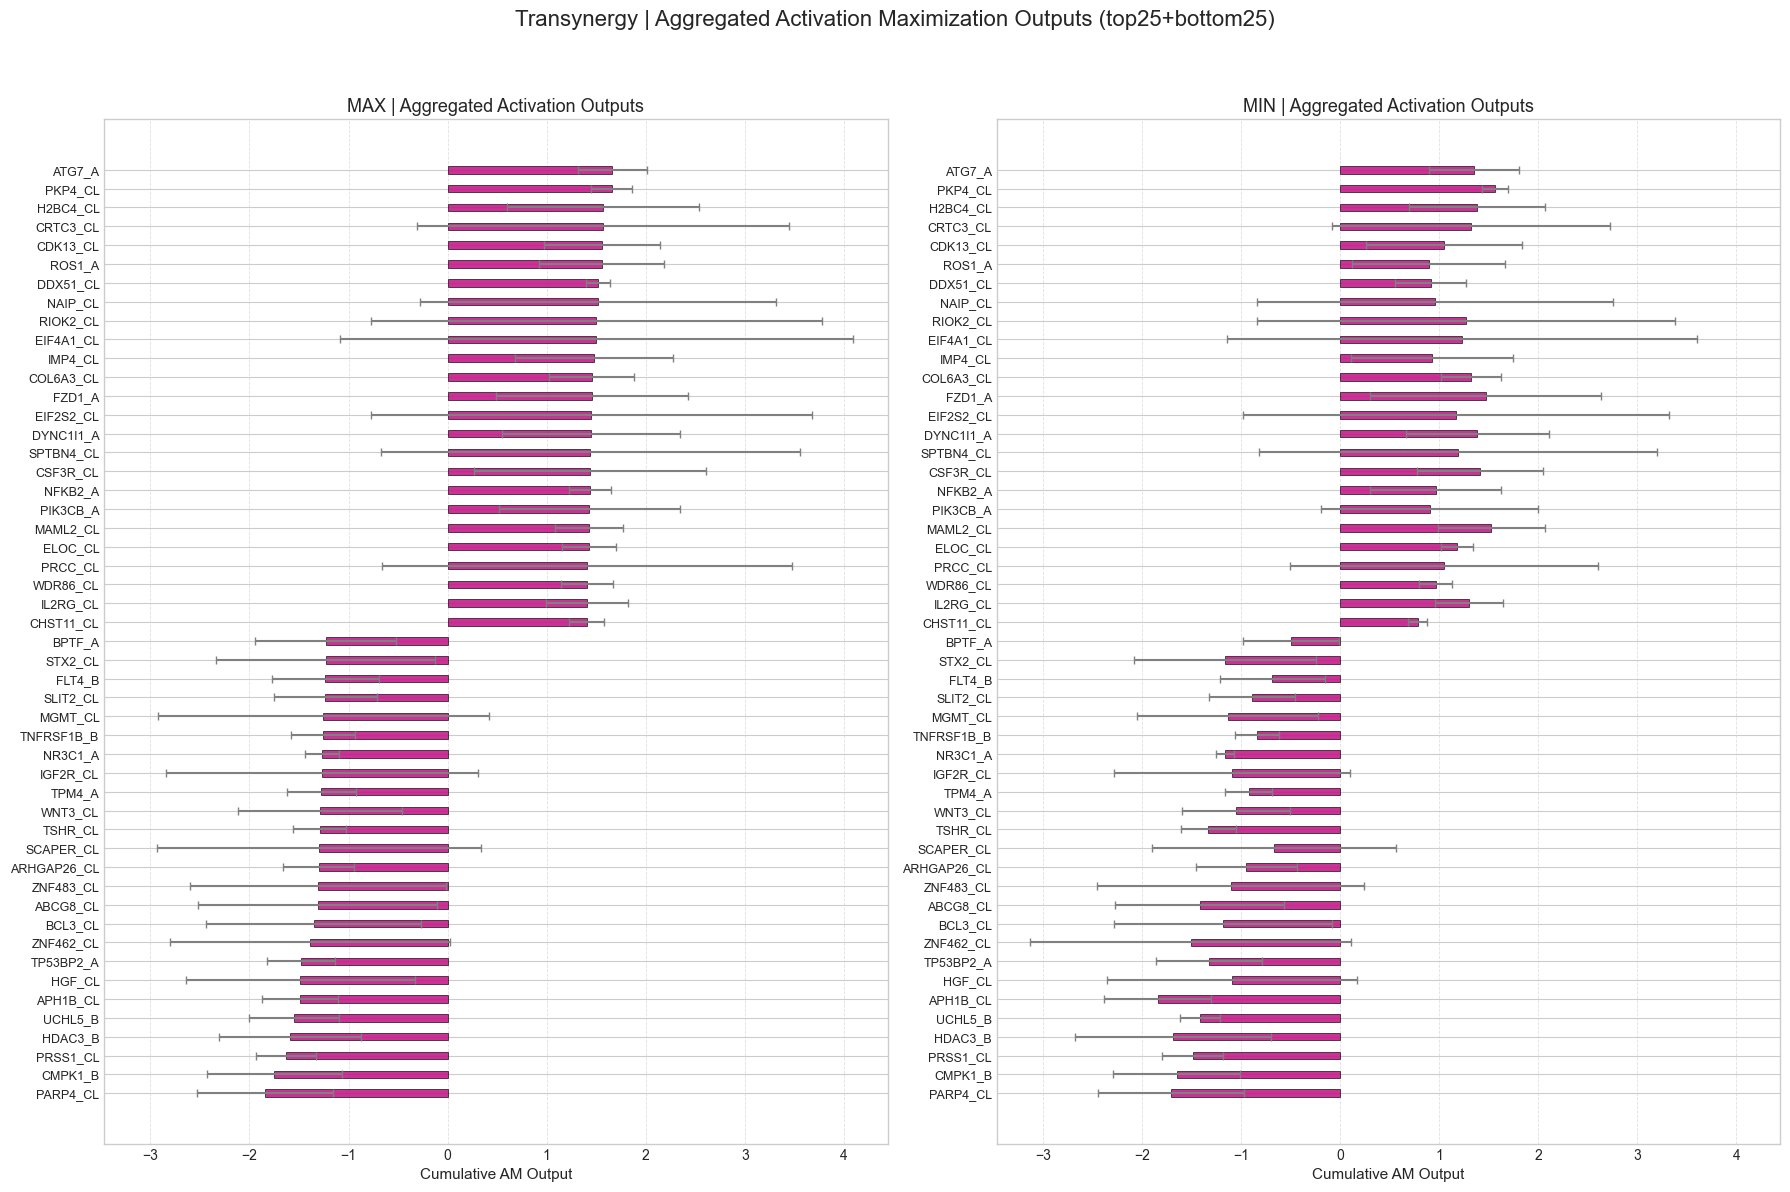

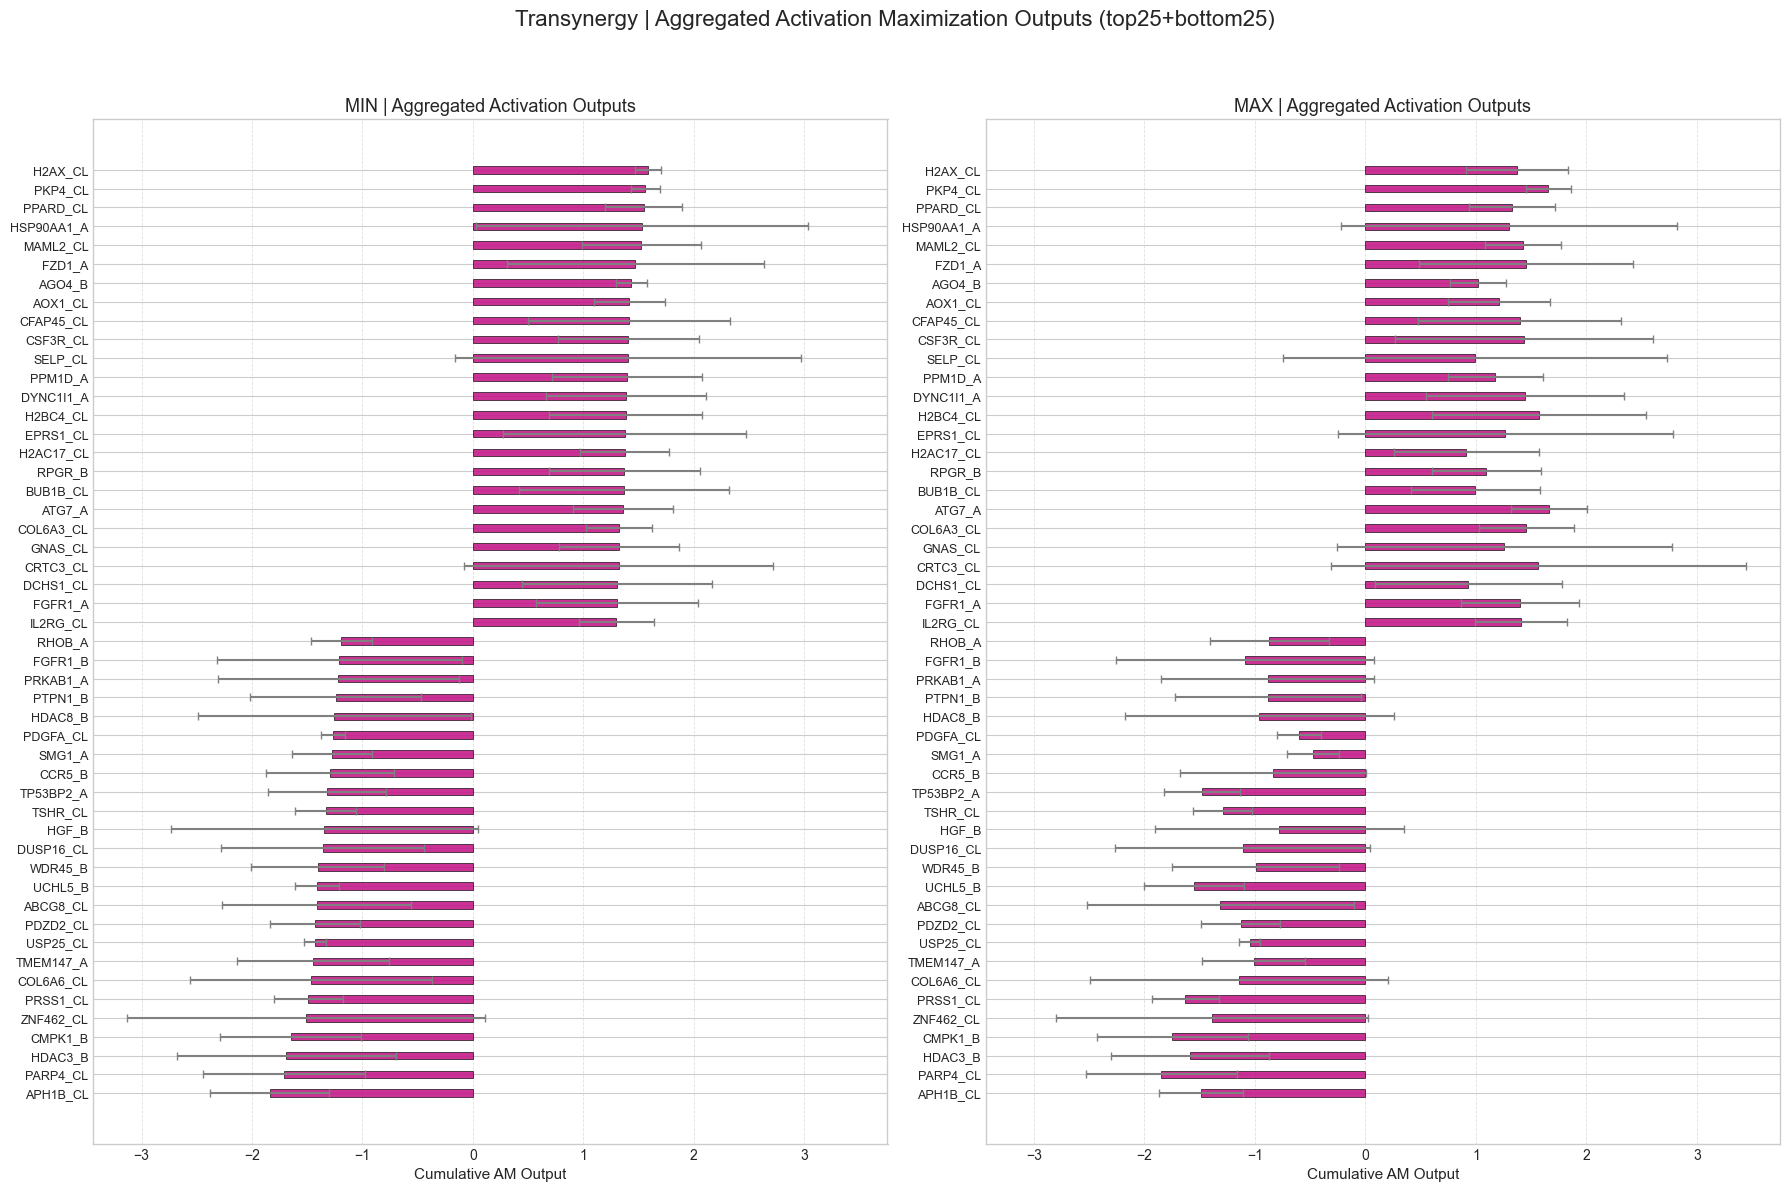

In [21]:
import matplotlib.pyplot as plt
import torch
import os
import matplotlib.ticker as ticker

for paper in papers:
    feature_names = ExplainationConfig(paper=paper).feature_names
    for minimaxis in [["max", "min"], ["min", "max"]]:
        SORTED_ORDER_INDICES = None
        dict_papers_indices_l2 = {}

        # Decide number of features to plot
        if len(feature_names) > 50:
            height = 25 + 25
            suffix = "(top25+bottom25)"
        else:
            height = len(feature_names)
            suffix = ""

        fig, axes = plt.subplots(1, 2, figsize=(18, max(6, height * 0.25)))

        for ax_idx, minimax in enumerate(minimaxis):
            feature_importance = torch.zeros(len(feature_names))
            for reg in ["l2_input"]:
                path_to_experiment = os.path.join(os.getcwd(), f"explainability/am/results/{paper}_{minimax}_reg_{reg}")
                for file in os.listdir(path_to_experiment):
                    if file.endswith(".pt"):
                        tensor = torch.load(os.path.join(path_to_experiment, file))
                        feature_importance += tensor
            feature_importance /= (5)
            importance_values = feature_importance.tolist()

            full_sorted_indices = sorted(range(len(importance_values)), key=lambda i: importance_values[i], reverse=True)
            dict_papers_indices_l2[(paper, minimax)] = full_sorted_indices

            if SORTED_ORDER_INDICES is None:
                if len(feature_names) > 50:
                    top_25 = full_sorted_indices[:25]
                    bottom_25 = full_sorted_indices[-25:]
                    SORTED_ORDER_INDICES = top_25 + bottom_25
                else:
                    SORTED_ORDER_INDICES = full_sorted_indices

            sorted_feature_names = [feature_names[i] for i in SORTED_ORDER_INDICES]
            sorted_values = [feature_importance[i] for i in SORTED_ORDER_INDICES]
            feature_variance = total_variances_by_config[(paper, minimax)]
            sorted_variances = [feature_variance[i] for i in sorted_feature_names]

            y = range(len(SORTED_ORDER_INDICES))
            bar_width = 0.4

            axes[ax_idx].barh(
                y,
                sorted_values,
                height=bar_width,
                color="#C51B8A",
                xerr=sorted_variances,
                ecolor='gray',
                alpha=0.9,
                capsize=3,
                linewidth=0.5,
                edgecolor="black"
            )

            axes[ax_idx].set_yticks(y)
            axes[ax_idx].set_yticklabels(sorted_feature_names, fontsize=9)
            axes[ax_idx].invert_yaxis()  # Most important on top
            axes[ax_idx].set_xlabel("Cumulative AM Output", fontsize=11)
            axes[ax_idx].set_title(f"{minimax.upper()} | Aggregated Activation Outputs", fontsize=13)
            axes[ax_idx].grid(axis='x', linestyle='--', linewidth=0.6, alpha=0.6)

        # Align x-axis across subplots
        x_lims = [ax.get_xlim() for ax in axes]
        x_min = min(lim[0] for lim in x_lims)
        x_max = max(lim[1] for lim in x_lims)
        for ax in axes:
            ax.set_xlim(x_min, x_max)

        # Global title
        plt.suptitle(f"{paper.capitalize()} | Aggregated Activation Maximization Outputs {suffix}", fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()


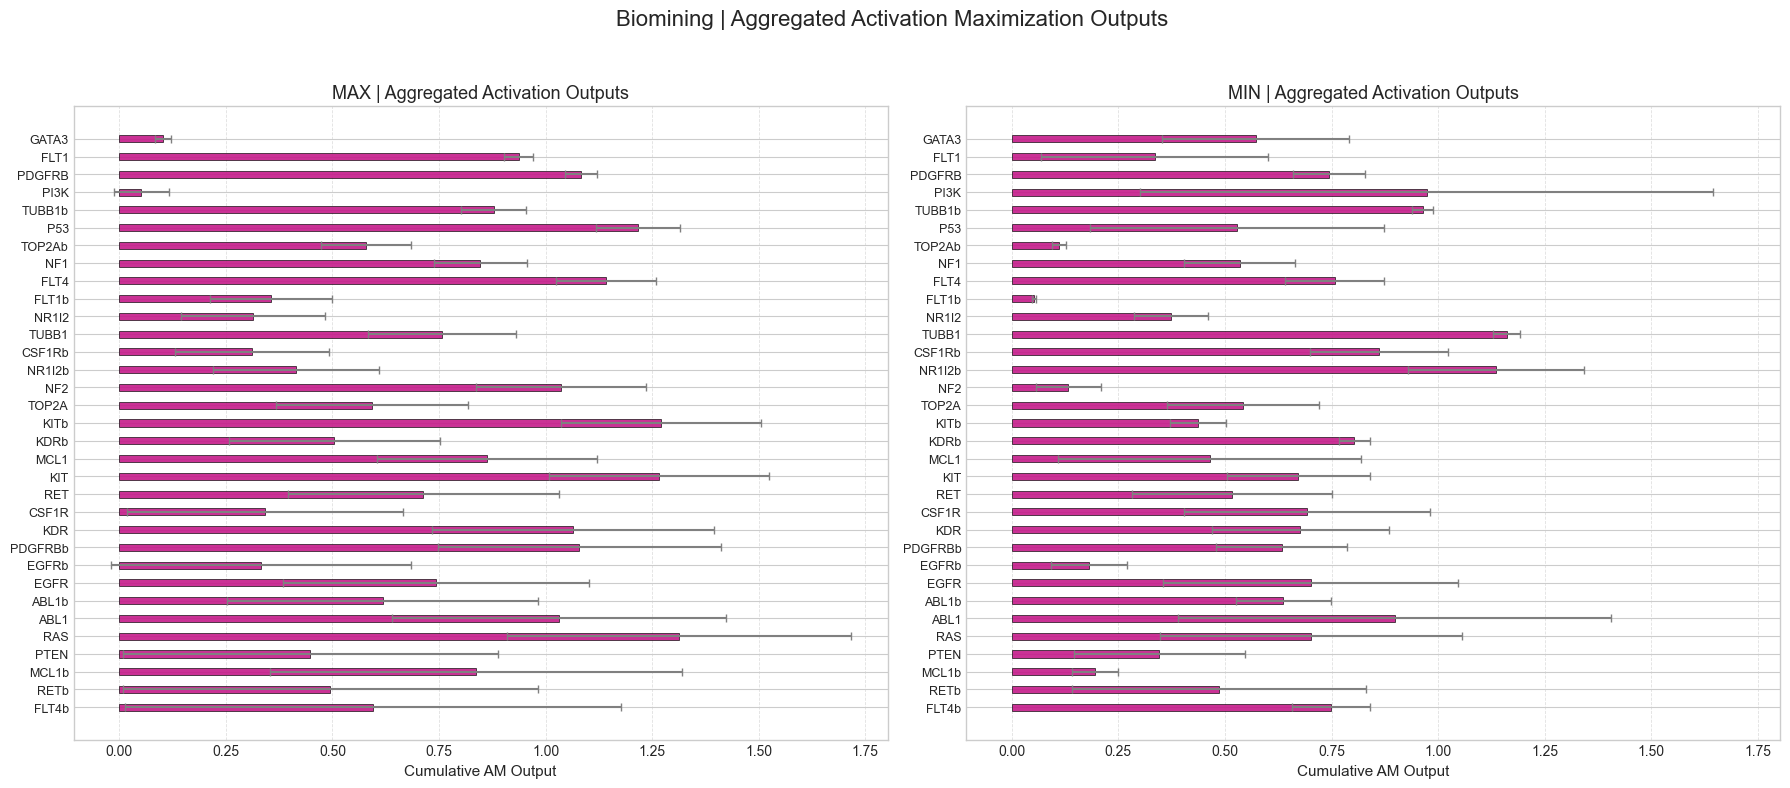

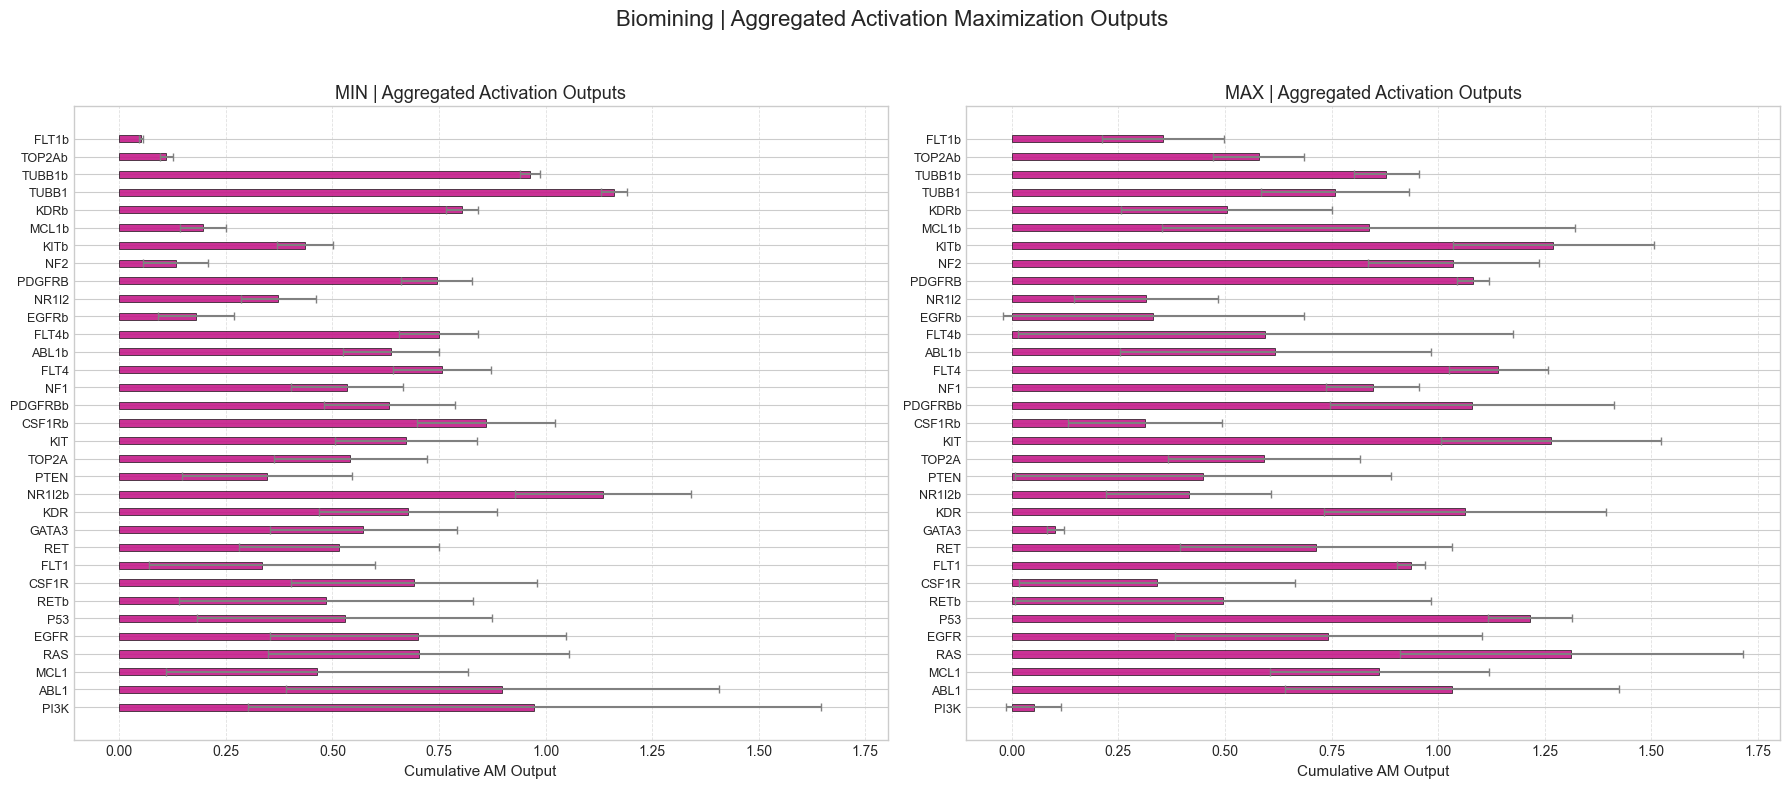

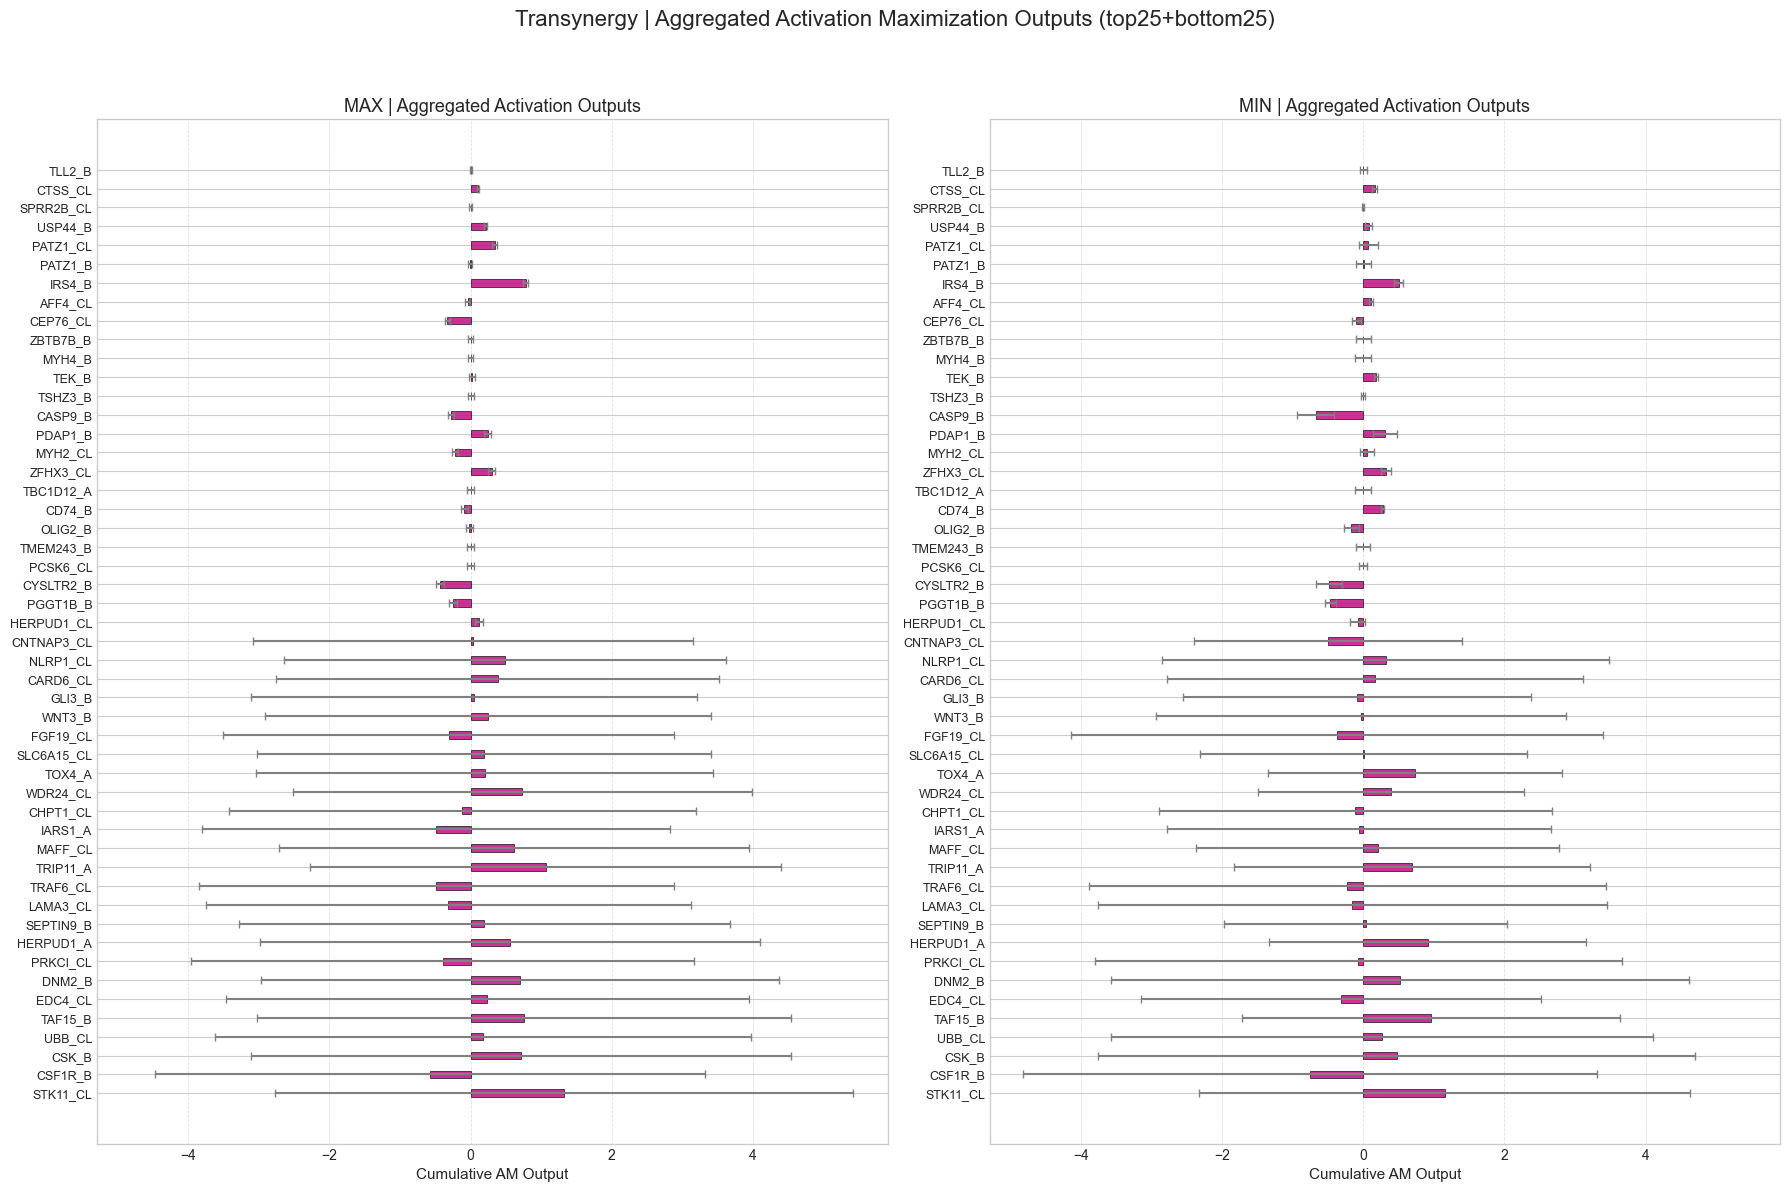

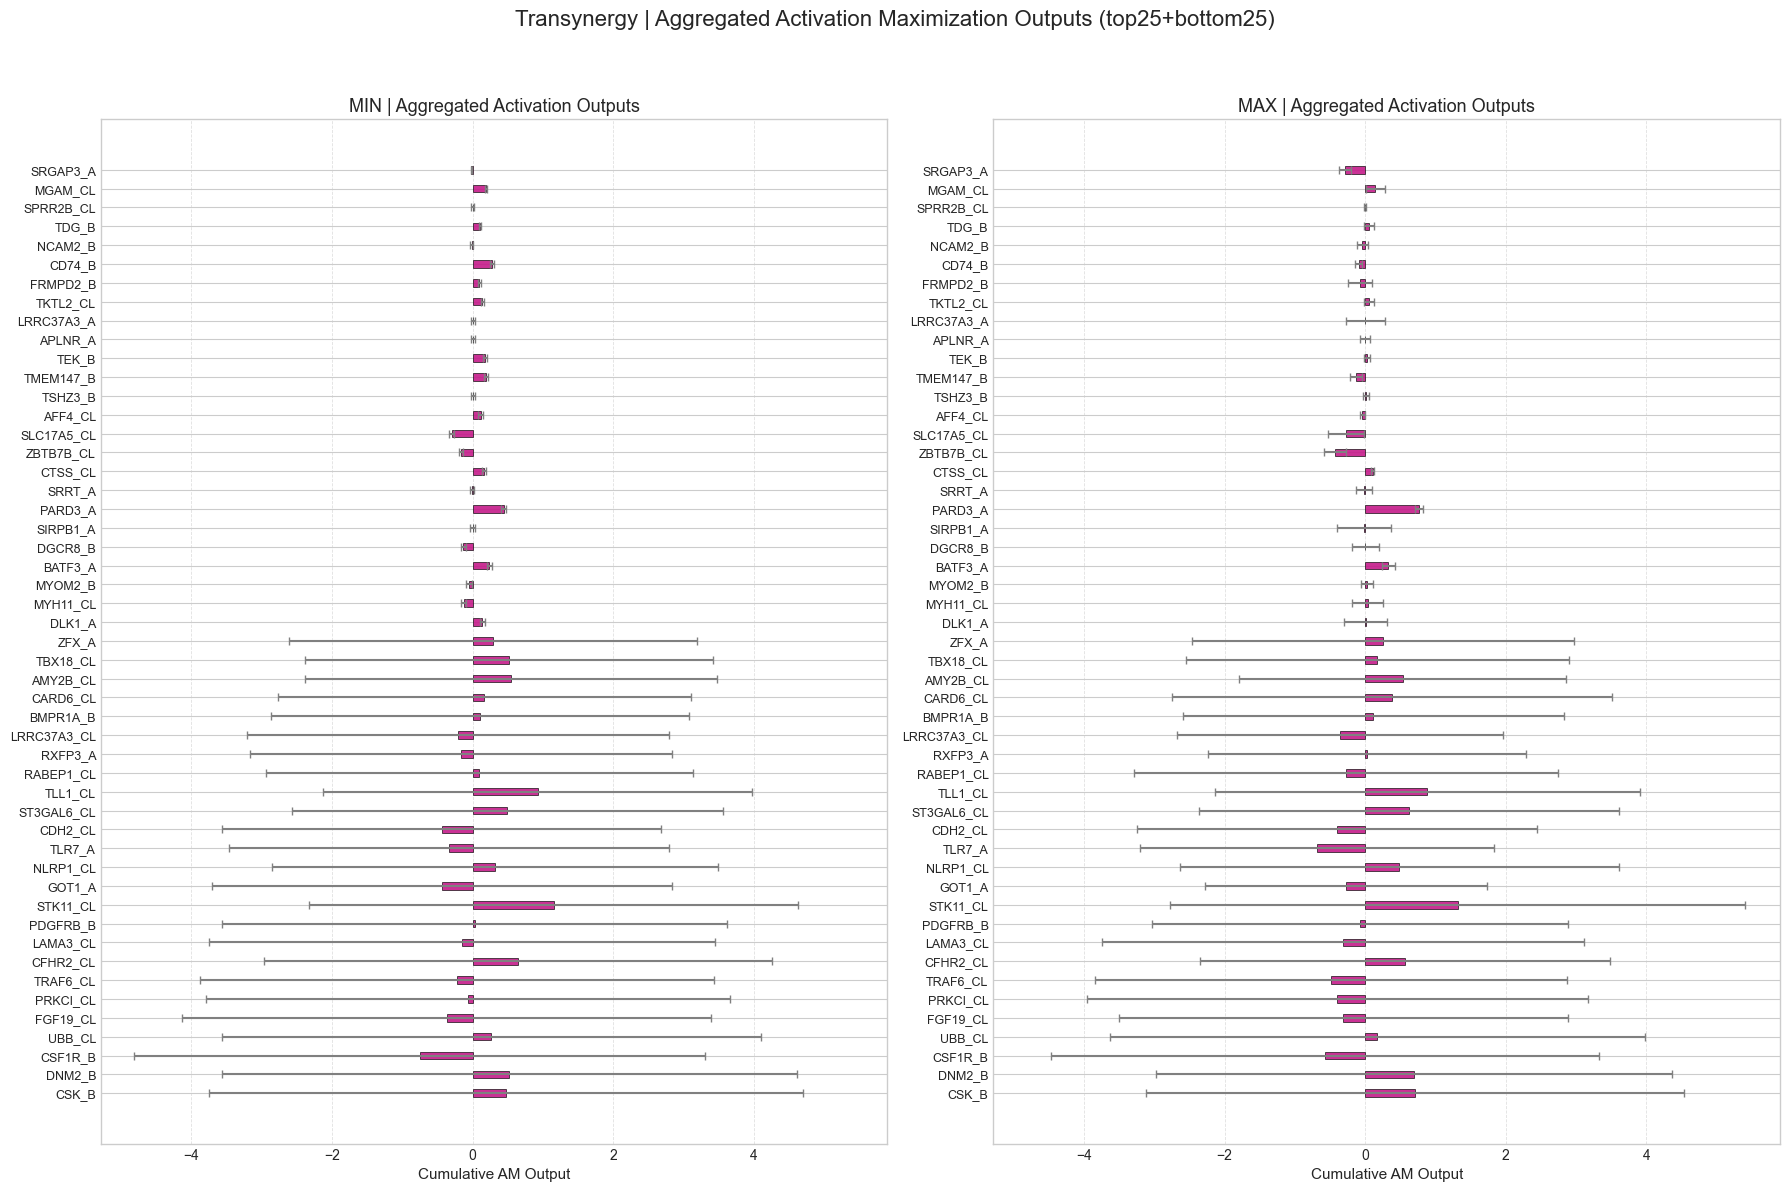

In [22]:
for paper in papers:
    feature_names = ExplainationConfig(paper=paper).feature_names
    for minimaxis in [["max", "min"], ["min", "max"]]:
        SORTED_ORDER_INDICES = None
        dict_papers_indices_l2 = {}

        # Decide number of features to plot
        if len(feature_names) > 50:
            height = 50
            suffix = "(top25+bottom25)"
        else:
            height = len(feature_names)
            suffix = ""

        fig, axes = plt.subplots(1, 2, figsize=(18, max(6, height * 0.25)))

        for ax_idx, minimax in enumerate(minimaxis):
            feature_importance = torch.zeros(len(feature_names))
            for reg in ["l2_input"]:
                path_to_experiment = os.path.join(os.getcwd(), f"explainability/am/results/{paper}_{minimax}_reg_{reg}")
                for file in os.listdir(path_to_experiment):
                    if file.endswith(".pt"):
                        tensor = torch.load(os.path.join(path_to_experiment, file))
                        feature_importance += tensor
            feature_importance /= (5 )

            feature_variance = total_variances_by_config[(paper, minimax)]

            # Sort by lowest variance
            full_sorted_indices = sorted(range(len(feature_names)), key=lambda i: feature_variance[feature_names[i]])

            dict_papers_indices_l2[(paper, minimax)] = full_sorted_indices

            if SORTED_ORDER_INDICES is None:
                if len(feature_names) > 50:
                    top_25 = full_sorted_indices[:25]
                    bottom_25 = full_sorted_indices[-25:]
                    SORTED_ORDER_INDICES = top_25 + bottom_25
                else:
                    SORTED_ORDER_INDICES = full_sorted_indices

            sorted_feature_names = [feature_names[i] for i in SORTED_ORDER_INDICES]
            sorted_values = [feature_importance[i] for i in SORTED_ORDER_INDICES]
            sorted_variances = [feature_variance[feature_names[i]] for i in SORTED_ORDER_INDICES]

            y = range(len(SORTED_ORDER_INDICES))
            bar_width = 0.4

            axes[ax_idx].barh(
                y,
                sorted_values,
                height=bar_width,
                color="#C51B8A",
                xerr=sorted_variances,
                ecolor='gray',
                alpha=0.9,
                capsize=3,
                linewidth=0.5,
                edgecolor="black"
            )

            axes[ax_idx].set_yticks(y)
            axes[ax_idx].set_yticklabels(sorted_feature_names, fontsize=9)
            axes[ax_idx].invert_yaxis()
            axes[ax_idx].set_xlabel("Cumulative AM Output", fontsize=11)
            axes[ax_idx].set_title(f"{minimax.upper()} | Aggregated Activation Outputs", fontsize=13)
            axes[ax_idx].grid(axis='x', linestyle='--', linewidth=0.6, alpha=0.6)

        # Align x-axis across subplots
        x_lims = [ax.get_xlim() for ax in axes]
        x_min = min(lim[0] for lim in x_lims)
        x_max = max(lim[1] for lim in x_lims)
        for ax in axes:
            ax.set_xlim(x_min, x_max)

        plt.suptitle(f"{paper.capitalize()} | Aggregated Activation Maximization Outputs {suffix}", fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()


In [ ]:
# !jupyter nbconvert --execute --to html explainability/explainability.ipynb
